In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(dada2)
require(phyloseq)
require(genefilter)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)
supressWarnings()

Loading required package: dada2

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘dada2’”


ERROR: Error in supressWarnings(): could not find function "supressWarnings"


In [3]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps_final.rds")

In [4]:
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 93542 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 93542 taxa by 6 taxonomic ranks ]

In [5]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))
ps_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 93542 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 93542 taxa by 6 taxonomic ranks ]

In [6]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps_norm, Kingdom=="Bacteria")
ps_norm_bac

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 82622 taxa and 57 samples ]
sample_data() Sample Data:       [ 57 samples by 95280 sample variables ]
tax_table()   Taxonomy Table:    [ 82622 taxa by 6 taxonomic ranks ]

In [7]:
#remove chloroplast order
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")

In [9]:
theme_set(theme_bw())

## using vegan to ordinate

In [8]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm_nochlo) {
  sd_nochlo <- sample_data(ps_norm_nochlo)
  return(as(sd_nochlo,"data.frame"))
}

#using phyloseq nmds plot no chloroplast
sample_nochlo <- pssd2veg(ps_norm_nochlo)


In [9]:
# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_norm_nochlo) {
  otu_nochlo <- otu_table(ps_norm_nochlo)
  if (taxa_are_rows(otu_nochlo)) {
    otu_nochlo <- t(otu_nochlo)
  }
  return(as(otu_nochlo, "matrix"))
}

# Extract normalized OTU matrix and sample data
otu_nochlo <- psotu2veg(ps_norm_nochlo)


In [10]:
head(sample_nochlo)

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACAGG,ATACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGTGTAGGCGGAACGATCAGTCGGAGGTGAAATCCCGGGGCTTAACCCCGGAACTGCCTTCGATACTATCGTTCTAGAGATCGGAAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGGAATTCGTAGATATTGGGAAGAACACCAGAGGCGAAGGCGACTCACTGGTCCGATACTGACGCTCAGACGCGAAAGTGTGGGGAGCAAACAGGA,⋯,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGCCGTGGTGTGTTTGGAGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCTTTTTAATGATACGGCGACCACCGAGATCTACACAATTCCGGTCGTCGGCAGCGTCAGATGTGTATAAGAGACAGGT,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACGCATGTCTATCTGGTGTGGCGGGGTTTGTTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,TCCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACAGGACATCTGGTGTGGCGGGGTGTGGTTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,input,filtered,denoisedF,denoisedR,merged,nonchim
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,580,0,⋯,0,0,0,0,189569,176082,171436,173162,142705,129120
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,0,0,⋯,0,0,0,0,98511,89332,88739,88868,87695,44586
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,279,6,⋯,0,0,0,0,280306,263766,262084,262620,250901,173382
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,328,0,⋯,0,0,0,0,536786,497419,495884,496191,481026,404922
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,0,0,⋯,0,0,0,0,163169,154836,154032,153929,151918,62656
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,0,128,⋯,0,0,0,0,22750,21151,20332,20453,19464,17819


### Cleaning sample norm

In [11]:
#cleaning up sample_norm to only be metadata
sample_clean <- sample_nochlo[, c("Health_Status", "colony", "Date_16S", "double_band", "date_sampled", "transect", "species", "MonthYear")]

In [12]:
# Should return TRUE
all(rownames(sample_clean) == rownames(otu_nochlo))

[1] TRUE

# Exploring the clustering using OHC (ovelapping cluster analysis), subgrouping dendograms

## subgrouping parent dendograms to visualize clustering within each Date_16S
from stack overflow

In [13]:
set.seed(12)

In [14]:
#making plots small 
options(repr.plot.width = 15, repr.plot.height = 10)

In [15]:
dij <- vegdist(otu_nochlo) ## bray curtis dissimilarity
clu <- hclust(dij, method = "average")
# 2 clusters bc I know Date_16S is already driving into 2 clusters
grp <- cutree(clu, 2)

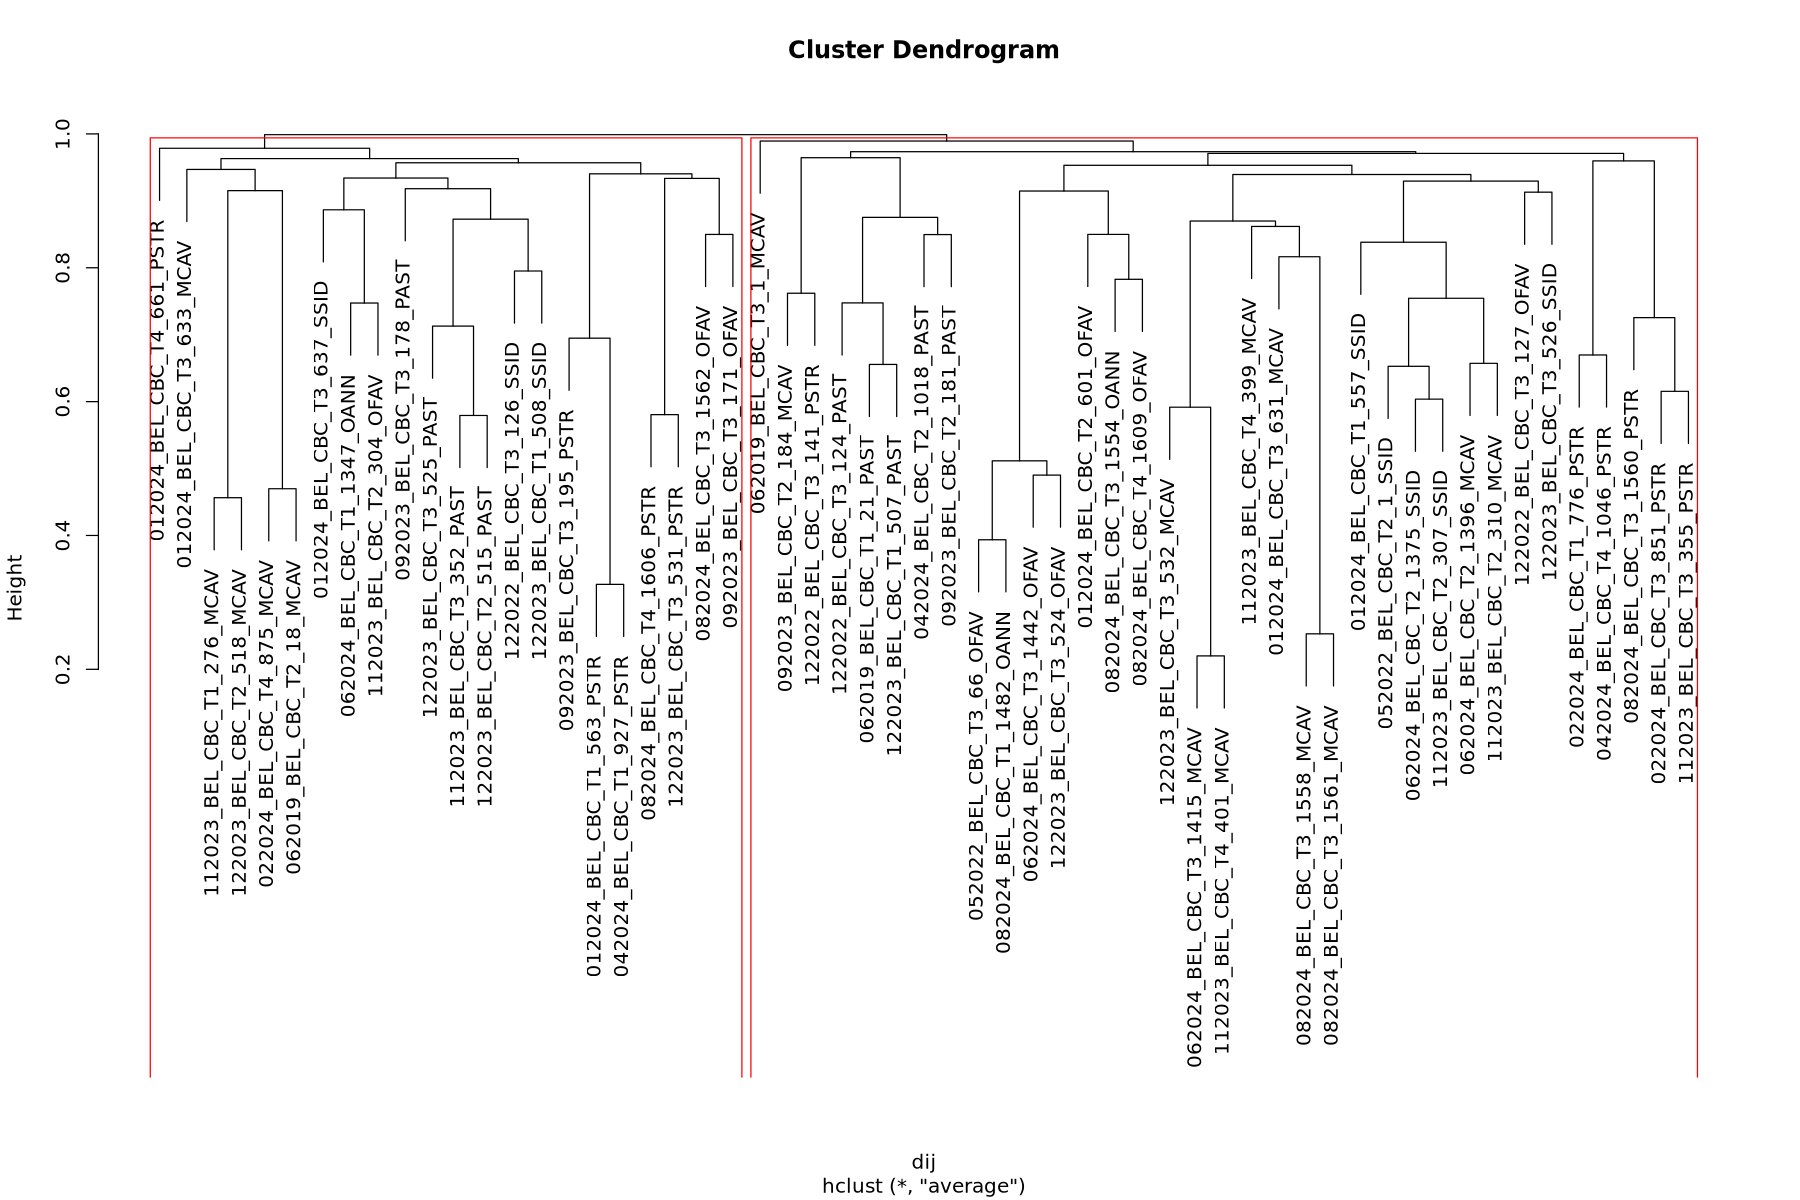

In [18]:
# visualizing the parent dendogram
plot(clu); rect.hclust(clu, k=2, border="red")

In [16]:
# Get indices of samples in each parent cluster
grp1_ids <- names(grp[grp == 1])
grp2_ids <- names(grp[grp == 2])

# Subset your original data
grp1_data <- otu_nochlo[grp1_ids, ]
grp2_data <- otu_nochlo[grp2_ids, ]

In [17]:
# now do clustering within each group
# Repeat the clustering within each group
dij1 <- vegdist(grp1_data)
clu1 <- hclust(dij1, method = "average")

dij2 <- vegdist(grp2_data)
clu2 <- hclust(dij2, method = "average")

# Cut into subclusters (you choose the depth, e.g., 2 or 3)
subgrp1 <- cutree(clu1, 4)
subgrp2 <- cutree(clu2, 4)

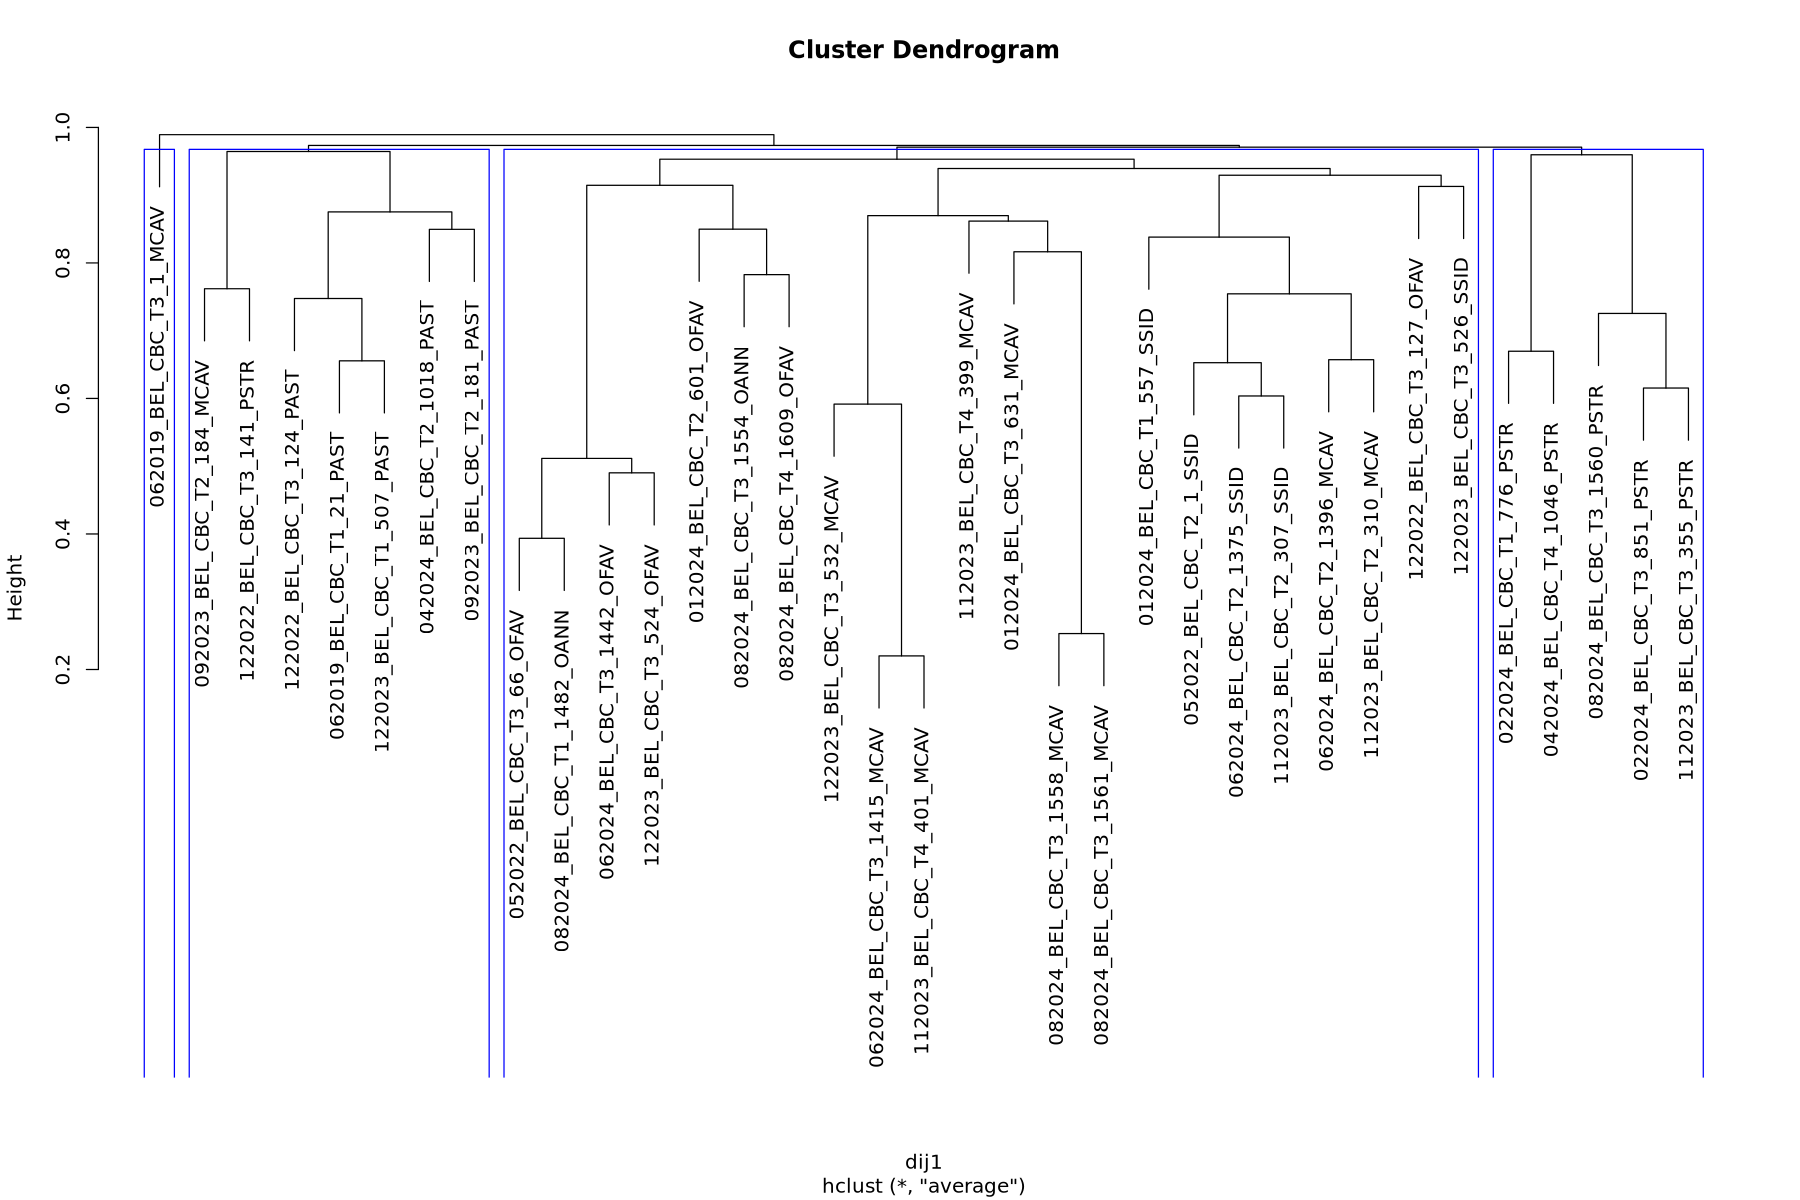

In [21]:
#plotting the sub groups
plot(clu1); rect.hclust(clu1, k = 4, border = "blue")

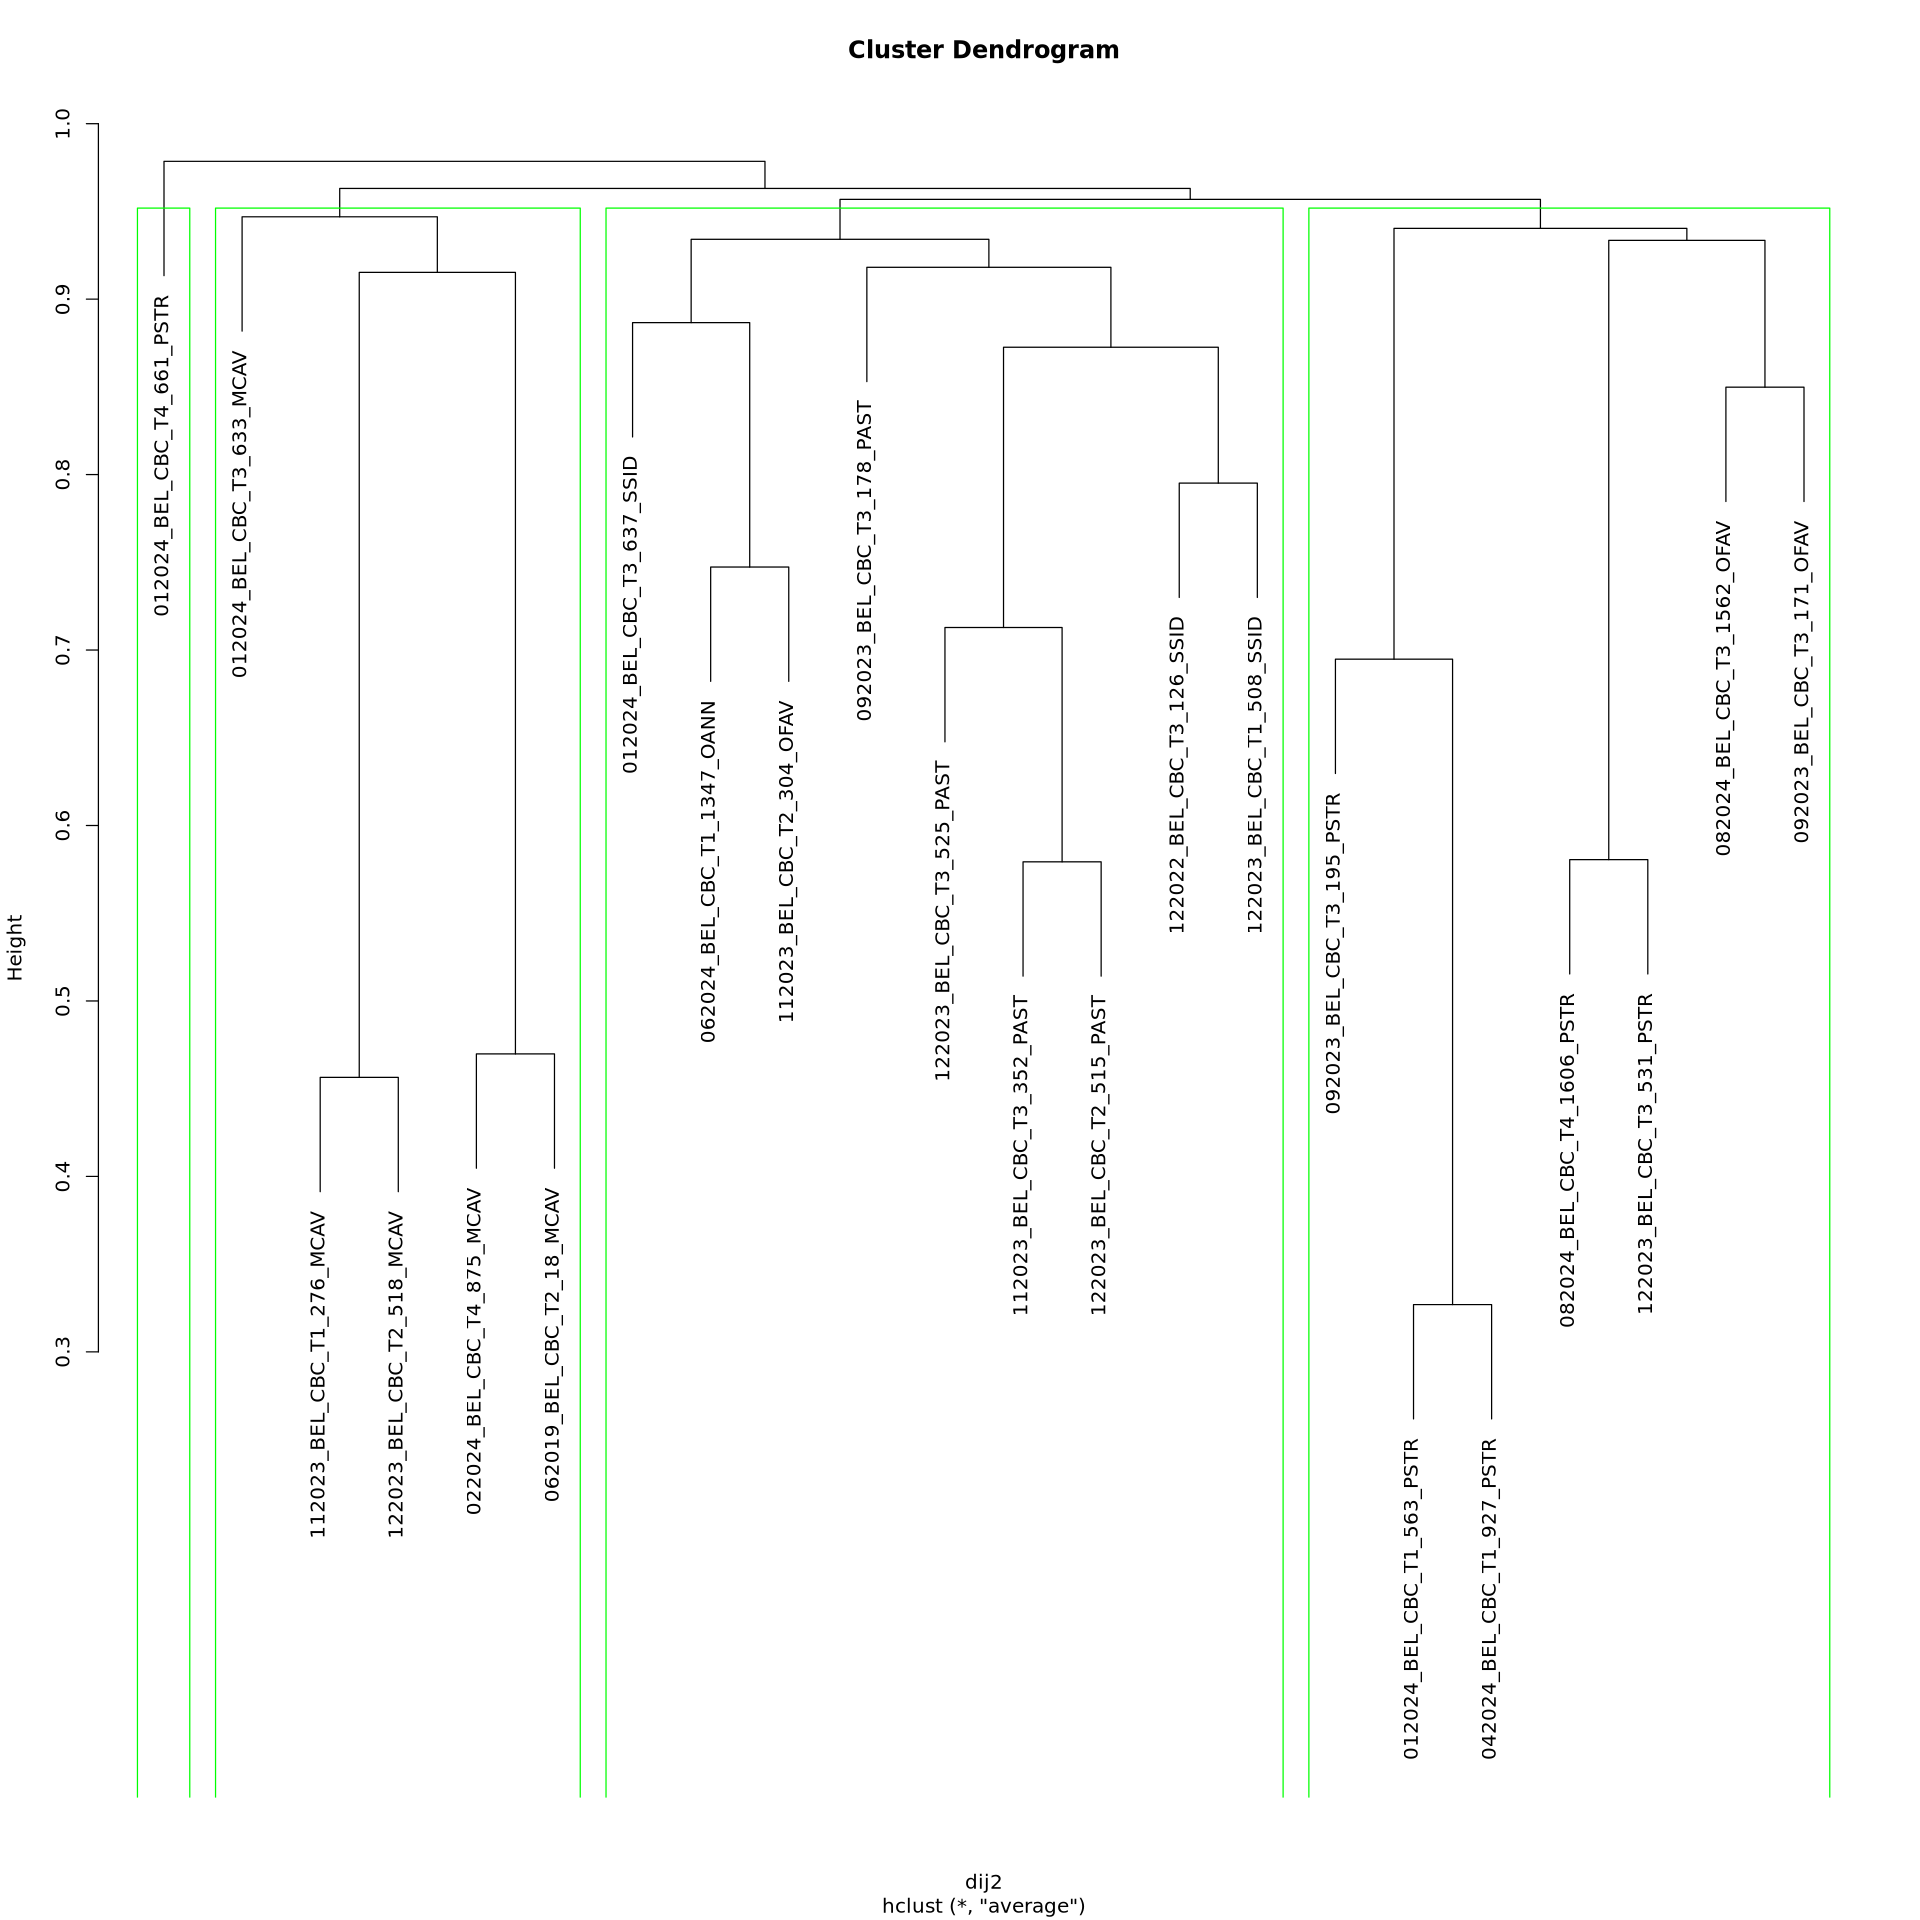

In [22]:
#making plots small 
options(repr.plot.width = 16, repr.plot.height = 16)
plot(clu2); rect.hclust(clu2, k = 4, border = "green")

In [23]:
#testing subgroups ecological relevance
adonis2(grp1_data ~ subgrp1, method = "bray")
adonis2(grp2_data ~ subgrp2, method = "bray")

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
subgrp1,1,1.016492,0.06680973,2.362563,0.001
Residual,33,14.198244,0.93319027,NA,NA
Total,34,15.214737,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
subgrp2,1,0.793153,0.08535148,1.866323,0.002
Residual,20,8.499633,0.91464852,NA,NA
Total,21,9.292786,1.00000000,NA,NA


## Now I am using those subgrouped dendograms to make an nmds plot that has subgroups visisble

In [39]:
# If you don`t provide a dissimilarity matrix, metaMDS automatically applies Bray-Curtis. So in our case, the results would have to be the same
nmds <- metaMDS(otu_nochlo, k = 2, trymax = 100, trace = F)
class(nmds)

Warning message in postMDS(out$points, dis, plot = max(0, plot - 1), ...):
“skipping half-change scaling: too few points below threshold”


[1] "metaMDS" "monoMDS"

In [40]:
# basically trying to turn nmds into a dataframe
#1. Extract only the samples from nmds
nmds_points <- as.data.frame(scores(nmds, display = "sites"))
# 2. Add sample IDs 
nmds_points$SampleID <- rownames(nmds_points)

In [41]:
# Convert to data frame for safe merging
#remember grp is what I named the parent clusters when I split them for the red dendogram
parent_df <- data.frame(
  SampleID = names(grp),
  ParentCluster = factor(grp)
)
# Merge parent cluster info with NMDS points
nmds_points <- merge(nmds_points, parent_df, by = "SampleID")

In [42]:
#combine subgrp1 and subgrp2 into a single "Subgroup" column with clear labels ex 1.1, 2.1, 1.2, 2.2
subgrp_names <- c(
  setNames(paste0("1.", subgrp1), names(subgrp1)),
  setNames(paste0("2.", subgrp2), names(subgrp2))
)
# Create a data frame of subgroups for safe merging
subgroup_df <- data.frame(
  SampleID = names(subgrp_names),
  Subgroup = factor(subgrp_names)
)
# Merge subgroup info with NMDS points
nmds_points <- merge(nmds_points, subgroup_df, by = "SampleID")

In [43]:
class(nmds)
class(sample_clean)
head(nmds_points)

[1] "metaMDS" "monoMDS"

[1] "data.frame"

,SampleID,NMDS1,NMDS2,ParentCluster,Subgroup
,<chr>,<dbl>,<dbl>,<fct>,<fct>
1,012024_BEL_CBC_T1_557_SSID,-0.2838910,0.03443425,1,1.1
2,012024_BEL_CBC_T1_563_PSTR,0.4841135,-0.12630331,2,2.1
3,012024_BEL_CBC_T2_601_OFAV,-0.2835469,-0.03883592,1,1.1
4,012024_BEL_CBC_T3_631_MCAV,-0.2560507,-0.10568941,1,1.1
5,012024_BEL_CBC_T3_633_MCAV,0.3534927,-0.03250394,2,2.2
6,012024_BEL_CBC_T3_637_SSID,0.4878788,-0.08246261,2,2.3


In [44]:
# what samples are in each parent cluster
nmds_points <- nmds_points[, c("SampleID", "ParentCluster")]
# Extract and reformat filename to "Tubelabel_species"
nmds_points <- nmds_points %>%
  mutate(
    SampleID = gsub("_", "-", paste0(nmds_points$SampleID, "_R1_16S_trim.fastq"))
  )
head(nmds_points)
write.csv(nmds_points, "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/parentcluster.csv", row.names = FALSE)

,SampleID,ParentCluster
,<chr>,<fct>
1,012024-BEL-CBC-T1-557-SSID-R1-16S-trim.fastq,1
2,012024-BEL-CBC-T1-563-PSTR-R1-16S-trim.fastq,2
3,012024-BEL-CBC-T2-601-OFAV-R1-16S-trim.fastq,1
4,012024-BEL-CBC-T3-631-MCAV-R1-16S-trim.fastq,1
5,012024-BEL-CBC-T3-633-MCAV-R1-16S-trim.fastq,2
6,012024-BEL-CBC-T3-637-SSID-R1-16S-trim.fastq,2


In [45]:
list1=nmds_points[nmds_points$ParentCluster=="1",]

In [47]:
list1$ParentCluster=NULL

In [50]:
rownames(list1)=NULL

In [54]:
list1 <- as.vector(list1)

In [56]:
class(list1)
head(list1)

[1] "list"

$SampleID
 [1] "012024-BEL-CBC-T1-557-SSID-R1-16S-trim.fastq" 
 [2] "012024-BEL-CBC-T2-601-OFAV-R1-16S-trim.fastq" 
 [3] "012024-BEL-CBC-T3-631-MCAV-R1-16S-trim.fastq" 
 [4] "022024-BEL-CBC-T1-776-PSTR-R1-16S-trim.fastq" 
 [5] "022024-BEL-CBC-T3-851-PSTR-R1-16S-trim.fastq" 
 [6] "042024-BEL-CBC-T2-1018-PAST-R1-16S-trim.fastq"
 [7] "042024-BEL-CBC-T4-1046-PSTR-R1-16S-trim.fastq"
 [8] "052022-BEL-CBC-T2-1-SSID-R1-16S-trim.fastq"   
 [9] "052022-BEL-CBC-T3-66-OFAV-R1-16S-trim.fastq"  
[10] "062019-BEL-CBC-T1-21-PAST-R1-16S-trim.fastq"  
[11] "062019-BEL-CBC-T3-1-MCAV-R1-16S-trim.fastq"   
[12] "062024-BEL-CBC-T2-1375-SSID-R1-16S-trim.fastq"
[13] "062024-BEL-CBC-T2-1396-MCAV-R1-16S-trim.fastq"
[14] "062024-BEL-CBC-T3-1415-MCAV-R1-16S-trim.fastq"
[15] "062024-BEL-CBC-T3-1442-OFAV-R1-16S-trim.fastq"
[16] "082024-BEL-CBC-T1-1482-OANN-R1-16S-trim.fastq"
[17] "082024-BEL-CBC-T3-1554-OANN-R1-16S-trim.fastq"
[18] "082024-BEL-CBC-T3-1558-MCAV-R1-16S-trim.fastq"
[19] "082024-BEL-CBC-T3-1560-PSTR-R1-16S-trim.fastq"
[20] "082024-BEL-CBC-T3-1561-MCAV-R1-16S-trim.fastq"
[21] "082024-BEL-CBC-T4-1609-OFAV-R1-16S-trim.fastq"
[22] "092023-BEL-CBC-T2-181-PAST-R1-16S-trim.fastq" 
[23] "092023-BEL-CBC-T2-184-MCAV-R1-16S-trim.fastq" 
[24] "112023-BEL-CBC-T2-307-SSID-R1-16S-trim.fastq" 
[25] "112023-BEL-CBC-T2-310-MCAV-R1-16S-trim.fastq" 
[26] "112023-BEL-CBC-T3-355-PSTR-R1-16S-trim.fastq" 
[27] "112023-BEL-CBC-T4-399-MCAV-R1-16S-trim.fastq" 
[28] "112023-BEL-CBC-T4-401-MCAV-R1-16S-trim.fastq" 
[29] "122022-BEL-CBC-T3-124-PAST-R1-16S-trim.fastq" 
[30] "122022-BEL-CBC-T3-127-OFAV-R1-16S-trim.fastq" 
[31] "122022-BEL-CBC-T3-141-PSTR-R1-16S-trim.fastq" 
[32] "122023-BEL-CBC-T1-507-PAST-R1-16S-trim.fastq" 
[33] "122023-BEL-CBC-T3-524-OFAV-R1-16S-trim.fastq" 
[34] "122023-BEL-CBC-T3-526-SSID-R1-16S-trim.fastq" 
[35] "122023-BEL-CBC-T3-532-MCAV-R1-16S-trim.fastq"

In [62]:
sink("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/parentlist.txt")         
print(list1)              
sink()  


$SampleID
 [1] "012024-BEL-CBC-T1-557-SSID-R1-16S-trim.fastq" 
 [2] "012024-BEL-CBC-T2-601-OFAV-R1-16S-trim.fastq" 
 [3] "012024-BEL-CBC-T3-631-MCAV-R1-16S-trim.fastq" 
 [4] "022024-BEL-CBC-T1-776-PSTR-R1-16S-trim.fastq" 
 [5] "022024-BEL-CBC-T3-851-PSTR-R1-16S-trim.fastq" 
 [6] "042024-BEL-CBC-T2-1018-PAST-R1-16S-trim.fastq"
 [7] "042024-BEL-CBC-T4-1046-PSTR-R1-16S-trim.fastq"
 [8] "052022-BEL-CBC-T2-1-SSID-R1-16S-trim.fastq"   
 [9] "052022-BEL-CBC-T3-66-OFAV-R1-16S-trim.fastq"  
[10] "062019-BEL-CBC-T1-21-PAST-R1-16S-trim.fastq"  
[11] "062019-BEL-CBC-T3-1-MCAV-R1-16S-trim.fastq"   
[12] "062024-BEL-CBC-T2-1375-SSID-R1-16S-trim.fastq"
[13] "062024-BEL-CBC-T2-1396-MCAV-R1-16S-trim.fastq"
[14] "062024-BEL-CBC-T3-1415-MCAV-R1-16S-trim.fastq"
[15] "062024-BEL-CBC-T3-1442-OFAV-R1-16S-trim.fastq"
[16] "082024-BEL-CBC-T1-1482-OANN-R1-16S-trim.fastq"
[17] "082024-BEL-CBC-T3-1554-OANN-R1-16S-trim.fastq"
[18] "082024-BEL-CBC-T3-1558-MCAV-R1-16S-trim.fastq"
[19] "082024-BEL-CBC-T3-1560-PSTR-R1

In [29]:
#merge nmds points with sample metadata
# easy merging by making sure sample metadata has a $SampleID column to match nmds_points 
sample_clean$SampleID <- rownames(sample_clean) 
# Merge using new SampleID column
nmds_merged <- merge(nmds_points, sample_clean, by = "SampleID")

In [30]:
any(duplicated(colnames(nmds_merged)))
colnames(nmds_merged)[duplicated(colnames(nmds_merged))]

[1] FALSE

character(0)

## Final checks to make sure nmds and sample dataframes are ready to be compared in a ggplot

In [31]:
class(nmds_merged)
class(sample_clean)
head(sample_clean)
#removeing unnecessary columns from nmds_merged
nmds_merged$Subgroup.y.1 <- NULL 
nmds_merged$Subgroup.1 <- NULL 
nmds_merged$DateFormatted <- NULL
head(nmds_merged)

[1] "data.frame"

[1] "data.frame"

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,SampleID
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<chr>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,012024_BEL_CBC_T1_557_SSID
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,012024_BEL_CBC_T1_563_PSTR
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,012024_BEL_CBC_T2_601_OFAV
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,012024_BEL_CBC_T3_631_MCAV
012024_BEL_CBC_T3_633_MCAV,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024,012024_BEL_CBC_T3_633_MCAV
012024_BEL_CBC_T3_637_SSID,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024,012024_BEL_CBC_T3_637_SSID


,SampleID,NMDS1,NMDS2,ParentCluster,Subgroup,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
1,012024_BEL_CBC_T1_557_SSID,-0.2835524,0.03377480,1,1.1,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024
2,012024_BEL_CBC_T1_563_PSTR,0.4850724,-0.12664508,2,2.1,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024
3,012024_BEL_CBC_T2_601_OFAV,-0.2813875,-0.03826506,1,1.1,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024
4,012024_BEL_CBC_T3_631_MCAV,-0.2542158,-0.10754129,1,1.1,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024
5,012024_BEL_CBC_T3_633_MCAV,0.3525720,-0.04384454,2,2.2,Healthy,3_2,3_6_2025,,012024,T3,MCAV,Jan 2024
6,012024_BEL_CBC_T3_637_SSID,0.4910429,-0.08657757,2,2.3,Healthy,3_5,3_6_2025,,012024,T3,SSID,Jan 2024


## Using subgrouped nmds ordination to make new nmds plots

In [32]:
#wider plots
#making plots small 
options(repr.plot.width = 25, repr.plot.height = 8)
#color assignment
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(20)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_path()`).”


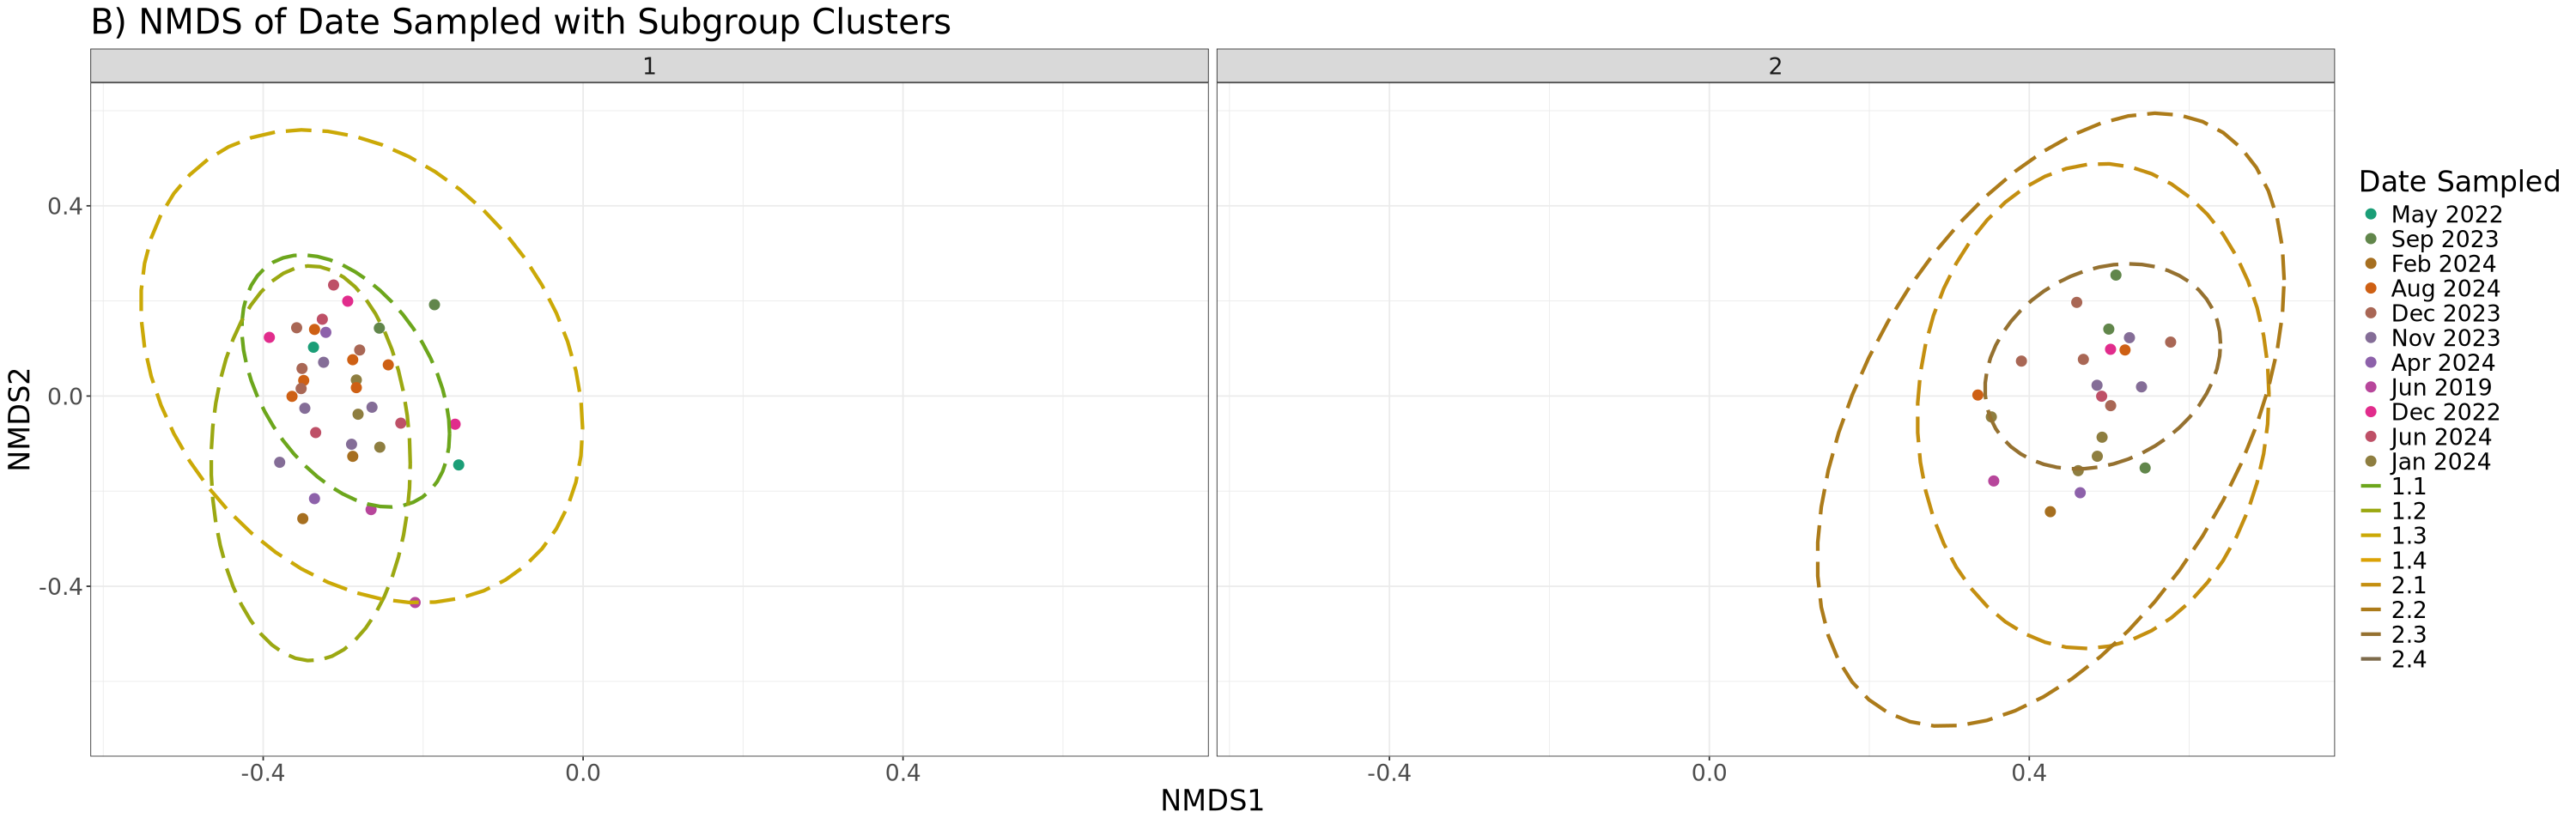

In [33]:
ggplot(nmds_merged, aes(NMDS1, NMDS2)) +
  # Points: color by MonthYear
  geom_point(aes(color = MonthYear), size = 3, alpha = 1) +
facet_wrap(~ ParentCluster) +
  guides(col = guide_legend(order = 1),
          shape = guide_legend(order = 2)) +
 theme(text = element_text(size = 20)) +
  #Ellipsoids: outline by Subgroup (dashed, same color palette)
stat_ellipse(
  aes(group = Subgroup, color = Subgroup),
  type = "norm",
  level = 0.95,
  linetype = "longdash",
  linewidth = 1.2,     # thicker lines
  alpha = 1            # fully opaque
) +
  
  #Use the same color palette for both
scale_color_manual(values = mycolors, drop = TRUE) +
  
  #Axis labels and theme
  labs(x = "NMDS1", y = "NMDS2", color = "Date Sampled", title = 'B) NMDS of Date Sampled with Subgroup Clusters')+
  theme(legend.position = "right")

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_path()`).”


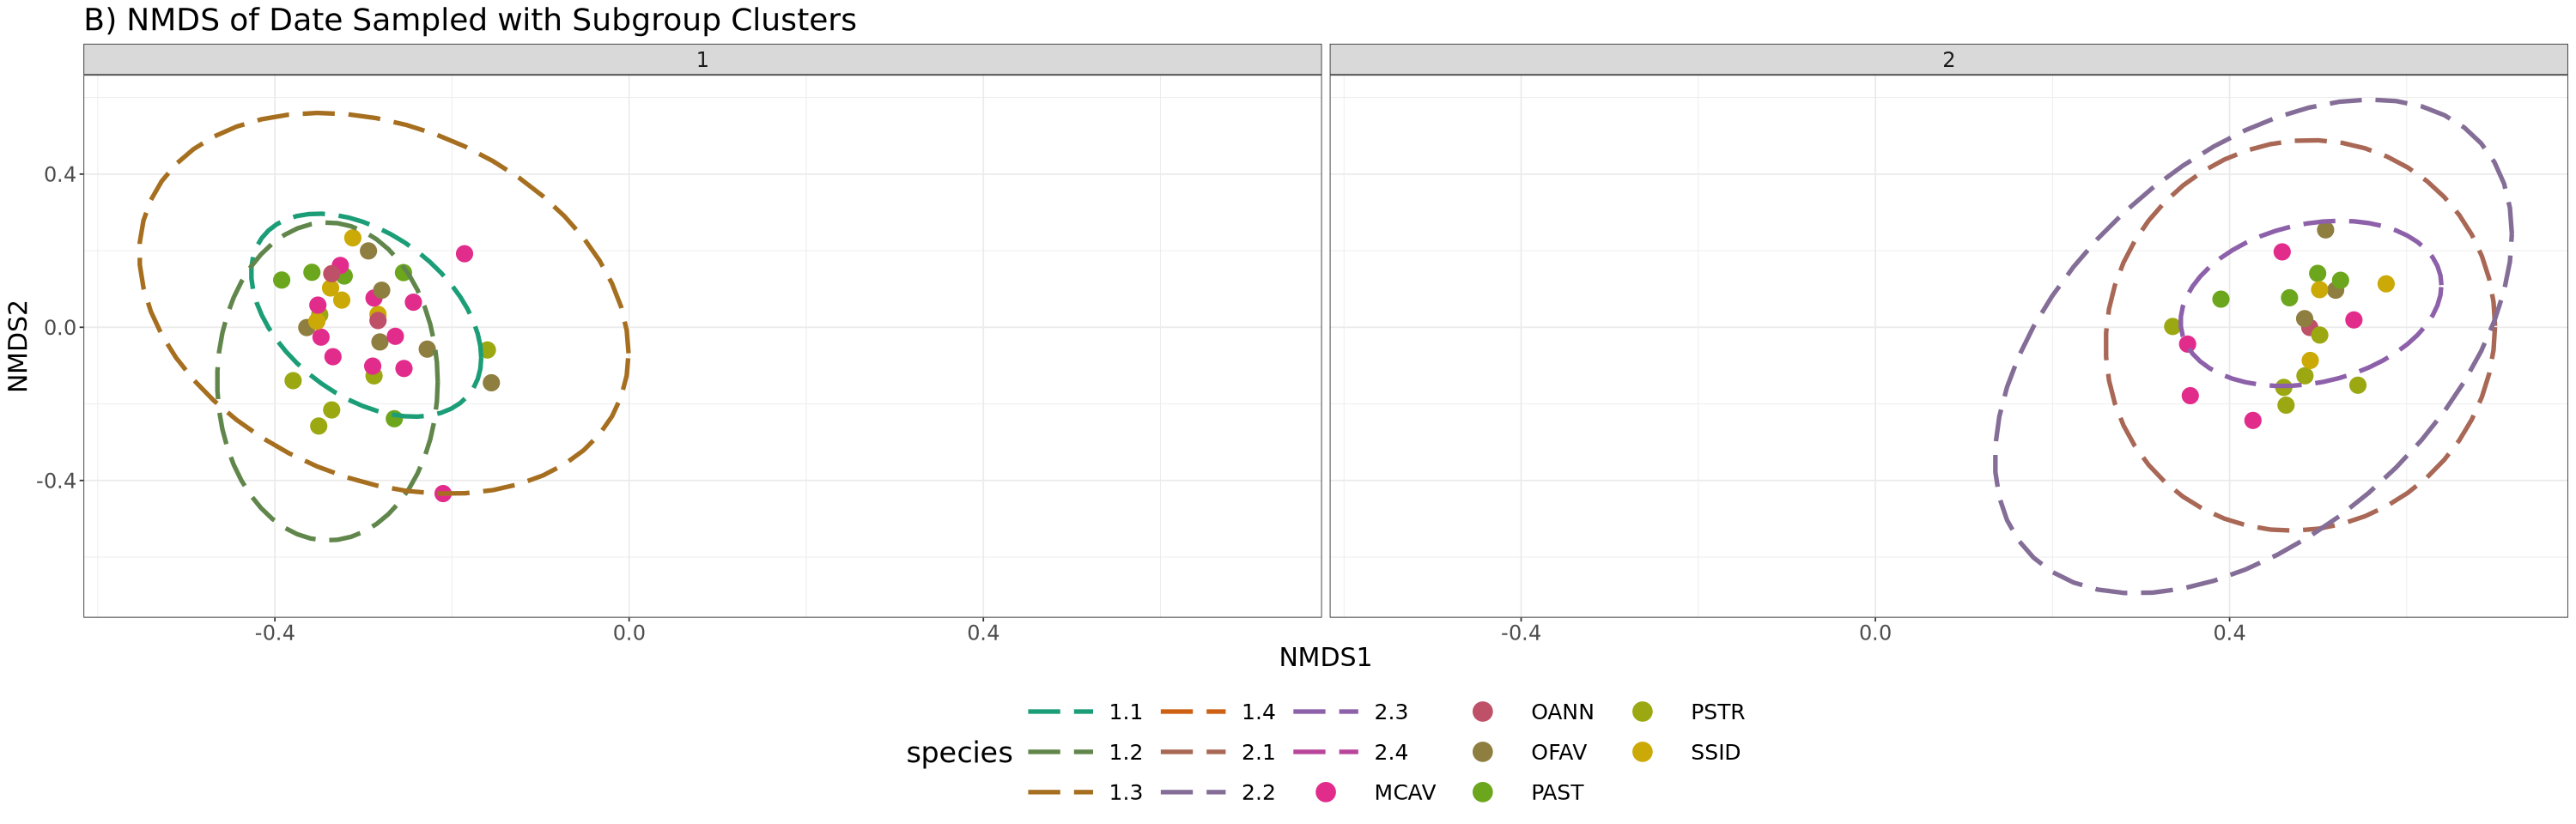

In [41]:
species_cluster <- ggplot(nmds_merged, aes(NMDS1, NMDS2)) +
  # Points: color by MonthYear
  geom_point(aes(color = species), size = 5, alpha = 1) +
facet_wrap(~ ParentCluster) +
  guides(col = guide_legend(order = 1),
          shape = guide_legend(order = 2)) +
 theme(text = element_text(size = 20)) +
  #Ellipsoids: outline by Subgroup (dashed, same color palette)
stat_ellipse(
  aes(group = Subgroup, color = Subgroup),
  type = "norm",
  level = 0.95,
  linetype = "longdash",
  linewidth = 1.5,     # thicker lines
  alpha = 1            # fully opaque
) +
  
  #Use the same color palette for both
scale_color_manual(values = mycolors, drop = TRUE) +
  
  #Axis labels and theme
  labs(x = "NMDS1", y = "NMDS2", color = "species", title = 'B) NMDS of Date Sampled with Subgroup Clusters')+
theme(
  legend.position = "bottom", 
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 18),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 6))) 
species_cluster

In [42]:
# Save the plot as a PNG
ggsave("/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/BEL_16S_outputs/plots/species_cluster.png", plot = species_cluster, width = 20, height = 10, units = "in", dpi = 300)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_path()`).”


## okay now I think what I want to do:
- find a way to do show the dendogram subgroups and hulls+dots for the species (or MonthYear) on the same plot
    - facet by ParentCluster
    - use color pallet "Dark2" to show subgroups as ellipses but very transparent
    - use "Set3" for the dots (opaque) and the convex hulls with spider lines
    

In [ ]:
warnings of Too few points to calculate an ellipse, considering using spiders or conve

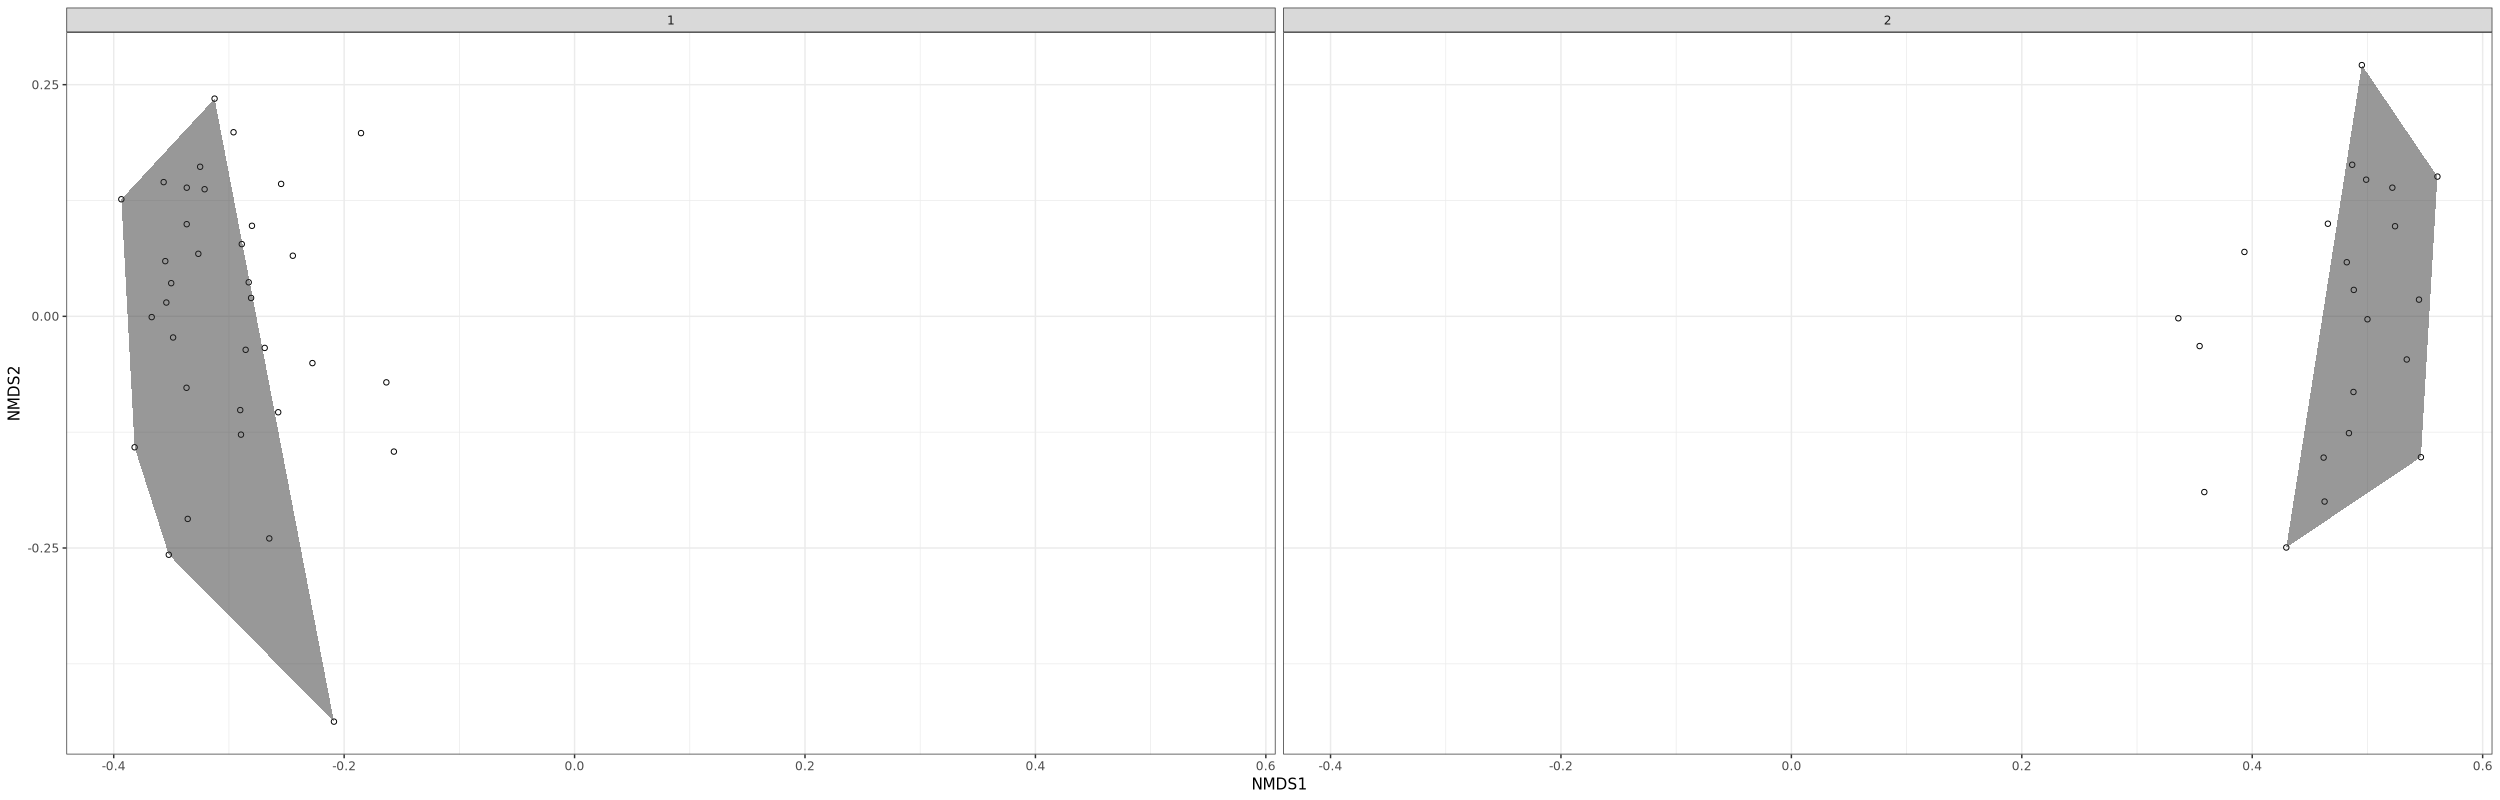

In [88]:
# Find the convex hull of the points being plotted
hull <- nmds_merged %>%
  slice(chull(NMDS1, NMDS2))

# Define the scatterplot
p <- ggplot(nmds_merged, aes(NMDS1, NMDS2)) + geom_point(shape = 21) +
    facet_wrap(~ ParentCluster) 

# Overlay the convex hull
p + geom_polygon(data = hull, alpha = 0.5)

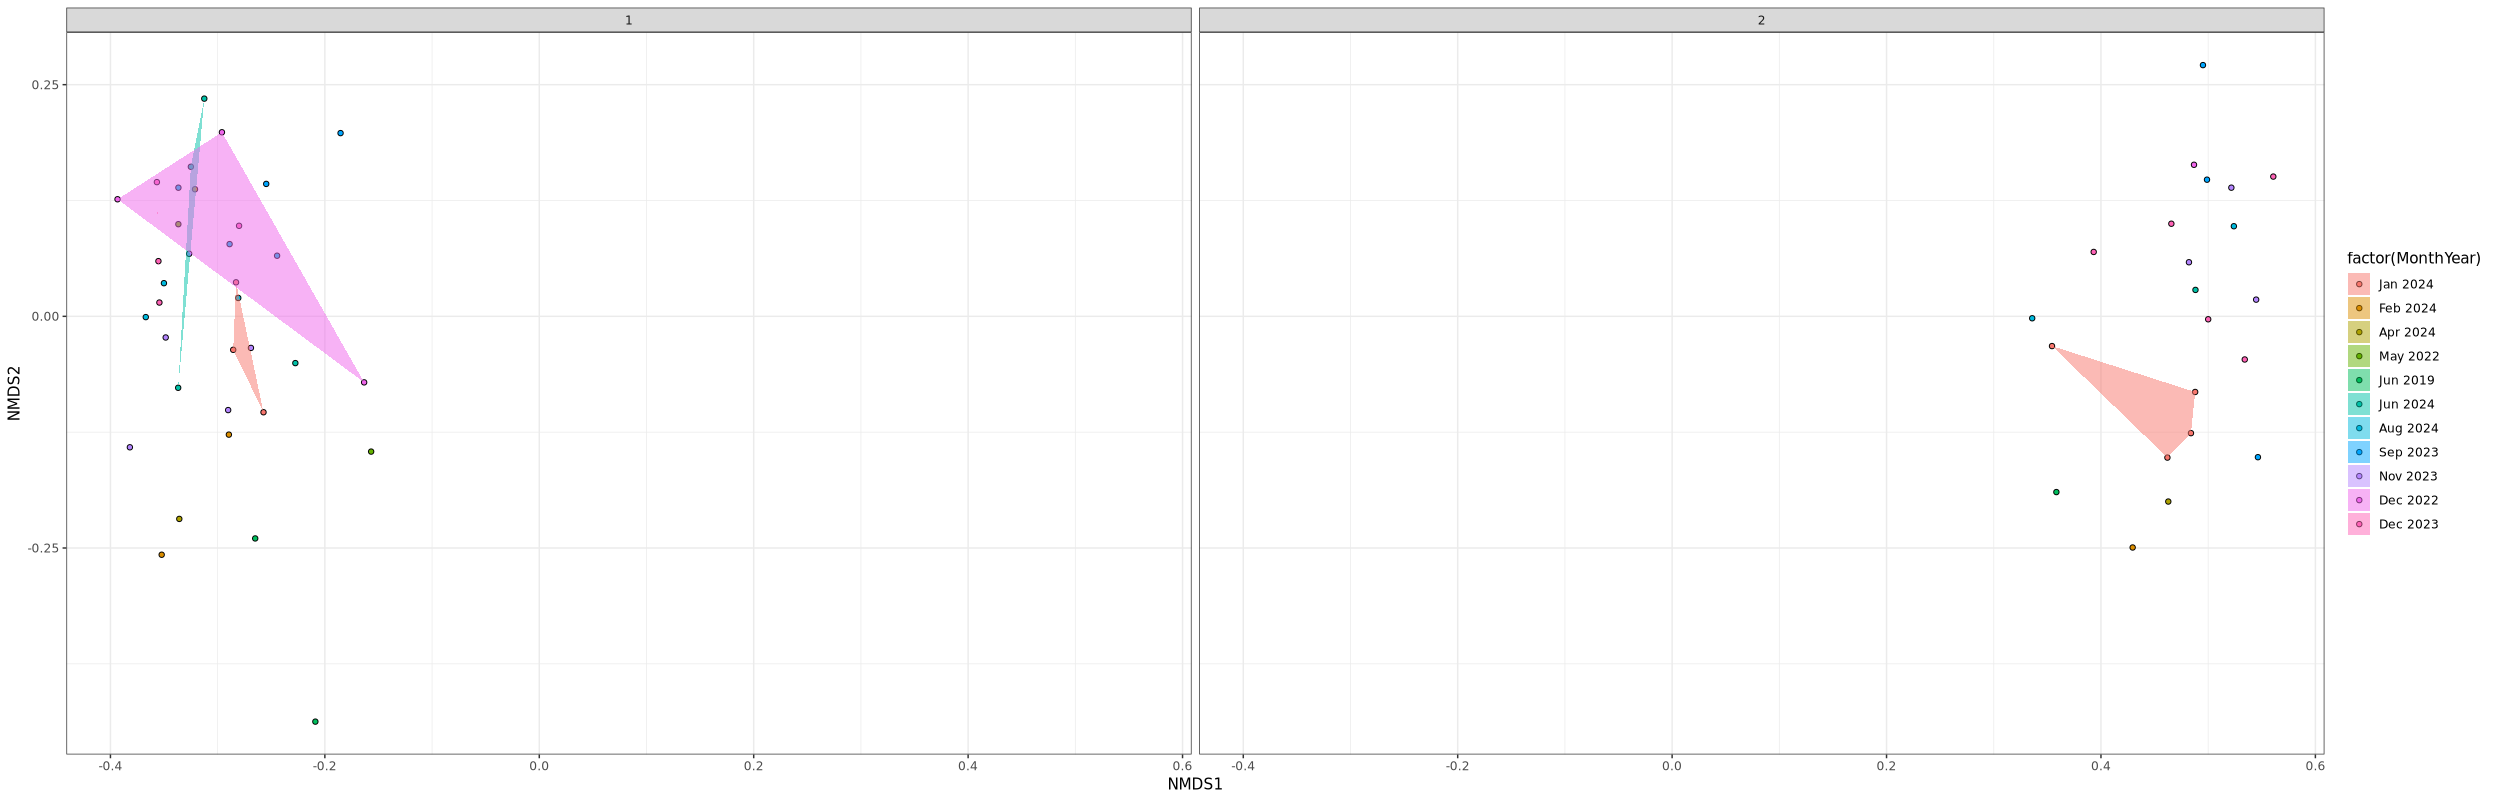

In [90]:
# Calculate the hulls for each group
hull_MonthYear <- nmds_merged %>%
  group_by(MonthYear) %>%
  slice(chull(NMDS1, NMDS2))

# Update the plot with a fill group, and overlay the new hulls
p + aes(fill = NA) + geom_polygon(data = hull_MonthYear, alpha = 0.5)

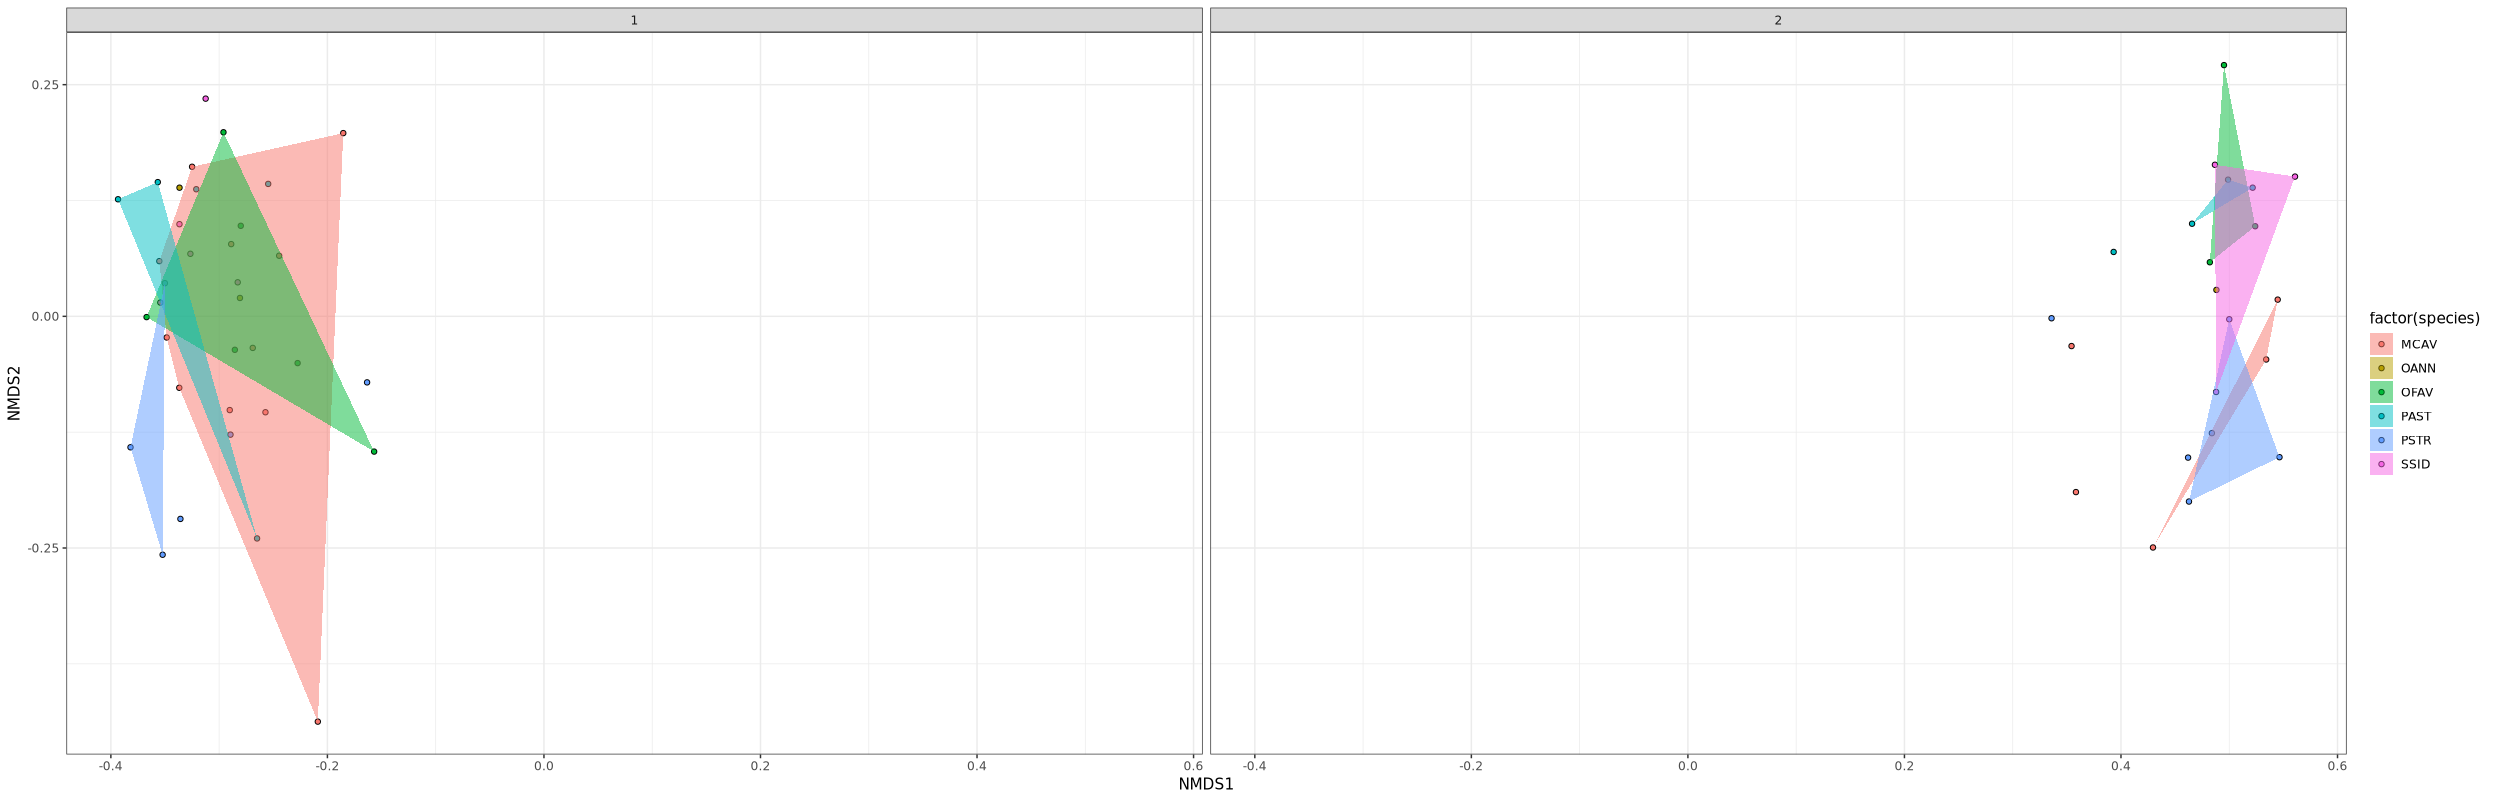

In [94]:
# Calculate the hulls for each group
hull_spec <- nmds_merged %>%
  group_by(species) %>%
  slice(chull(NMDS1, NMDS2))

# Update the plot with a fill group, and overlay the new hulls
p + aes(fill = factor(species)) + geom_polygon(data = hull_spec, alpha = 0.5)

#### vegan does not like facetting the same way that ggplot does 

In [141]:
# Convert clustering variables to factors for colors/faceting
nmds_merged <- nmds_merged %>%
  mutate(
    ParentCluster = factor(ParentCluster),
    species = factor(species),
    MonthYear = factor(MonthYear),
    Subgroup = factor(Subgroup)
  )

In [142]:
# Set the grouping variable to color by
color_var <- "species"

# Set up palettes
col_spec <- colorRampPalette(brewer.pal(12, "Set3"))(12)
names(col_spec) <- levels(nmds_merged[[color_var]])

col_subgrp <- colorRampPalette(brewer.pal(8, "Dark2"))(12)
names(col_subgrp) <- levels(nmds_merged$Subgroups)

####  AI trying to set up the facets before plotting so I can use vegan
doesn't really work

In [143]:
scl <- "symmetric"
site_scores <- scores(nmds, display = "sites", scaling = scl)  # ✅ Now site_scores is defined

In [163]:
# organizing color
# Use dark2 
# Step 1: Get all unique species
species_levels <- unique(nmds_merged$species)
species_levels
# Set up palettes
color_spec <- colorRampPalette(brewer.pal(8, "Dark2"))(6)
species_colors <- setNames(color_spec, species_levels)
# Step 3: Create the color vector
color_veg <- species_colors[nmds_merged$species]
unique(color_veg)

# Get unique ParentClusters
clusters <- unique(nmds_merged$ParentCluster)

# Set up plot layout: adjust rows/cols as needed
par(mfrow = c(1, length(clusters)))  # Change to c(2,2) for 4 clusters etc.
head(clusters)

[1] SSID PSTR OFAV MCAV PAST OANN
Levels: MCAV OANN OFAV PAST PSTR SSID

[1] "#666666" "#BF8B12" "#D03792" "#1B9E77" "#7FA718" "#B16548"

[1] 1 2
Levels: 1 2

In [ ]:
# Assume species is categorical
species_levels <- unique(nmds_merged$species)

# Use your predefined color vector (must match species count)
color_veg <- setNames(c('#666666', '#BF8B12', '#D03792', '#1B9E77', '#7FA718', '#B16548'), species_levels)

for (cl in clusters) {
  idx <- nmds_merged$ParentCluster == cl

  sub_scores <- site_scores[idx, , drop = FALSE]
  sub_species <- nmds_merged$species[idx]

  # Plot
  plot(sub_scores, type = "n", main = paste("Cluster:", cl))

  # Pass named color vector; vegan will match names to species levels
  ordihull(sub_scores, groups = sub_species, col = color_veg, lwd = 2)
  ordispider(sub_scores, groups = sub_species, col = color_veg, label = TRUE)

  points(sub_scores, pch = 21, col = "red", bg = "yellow")
}


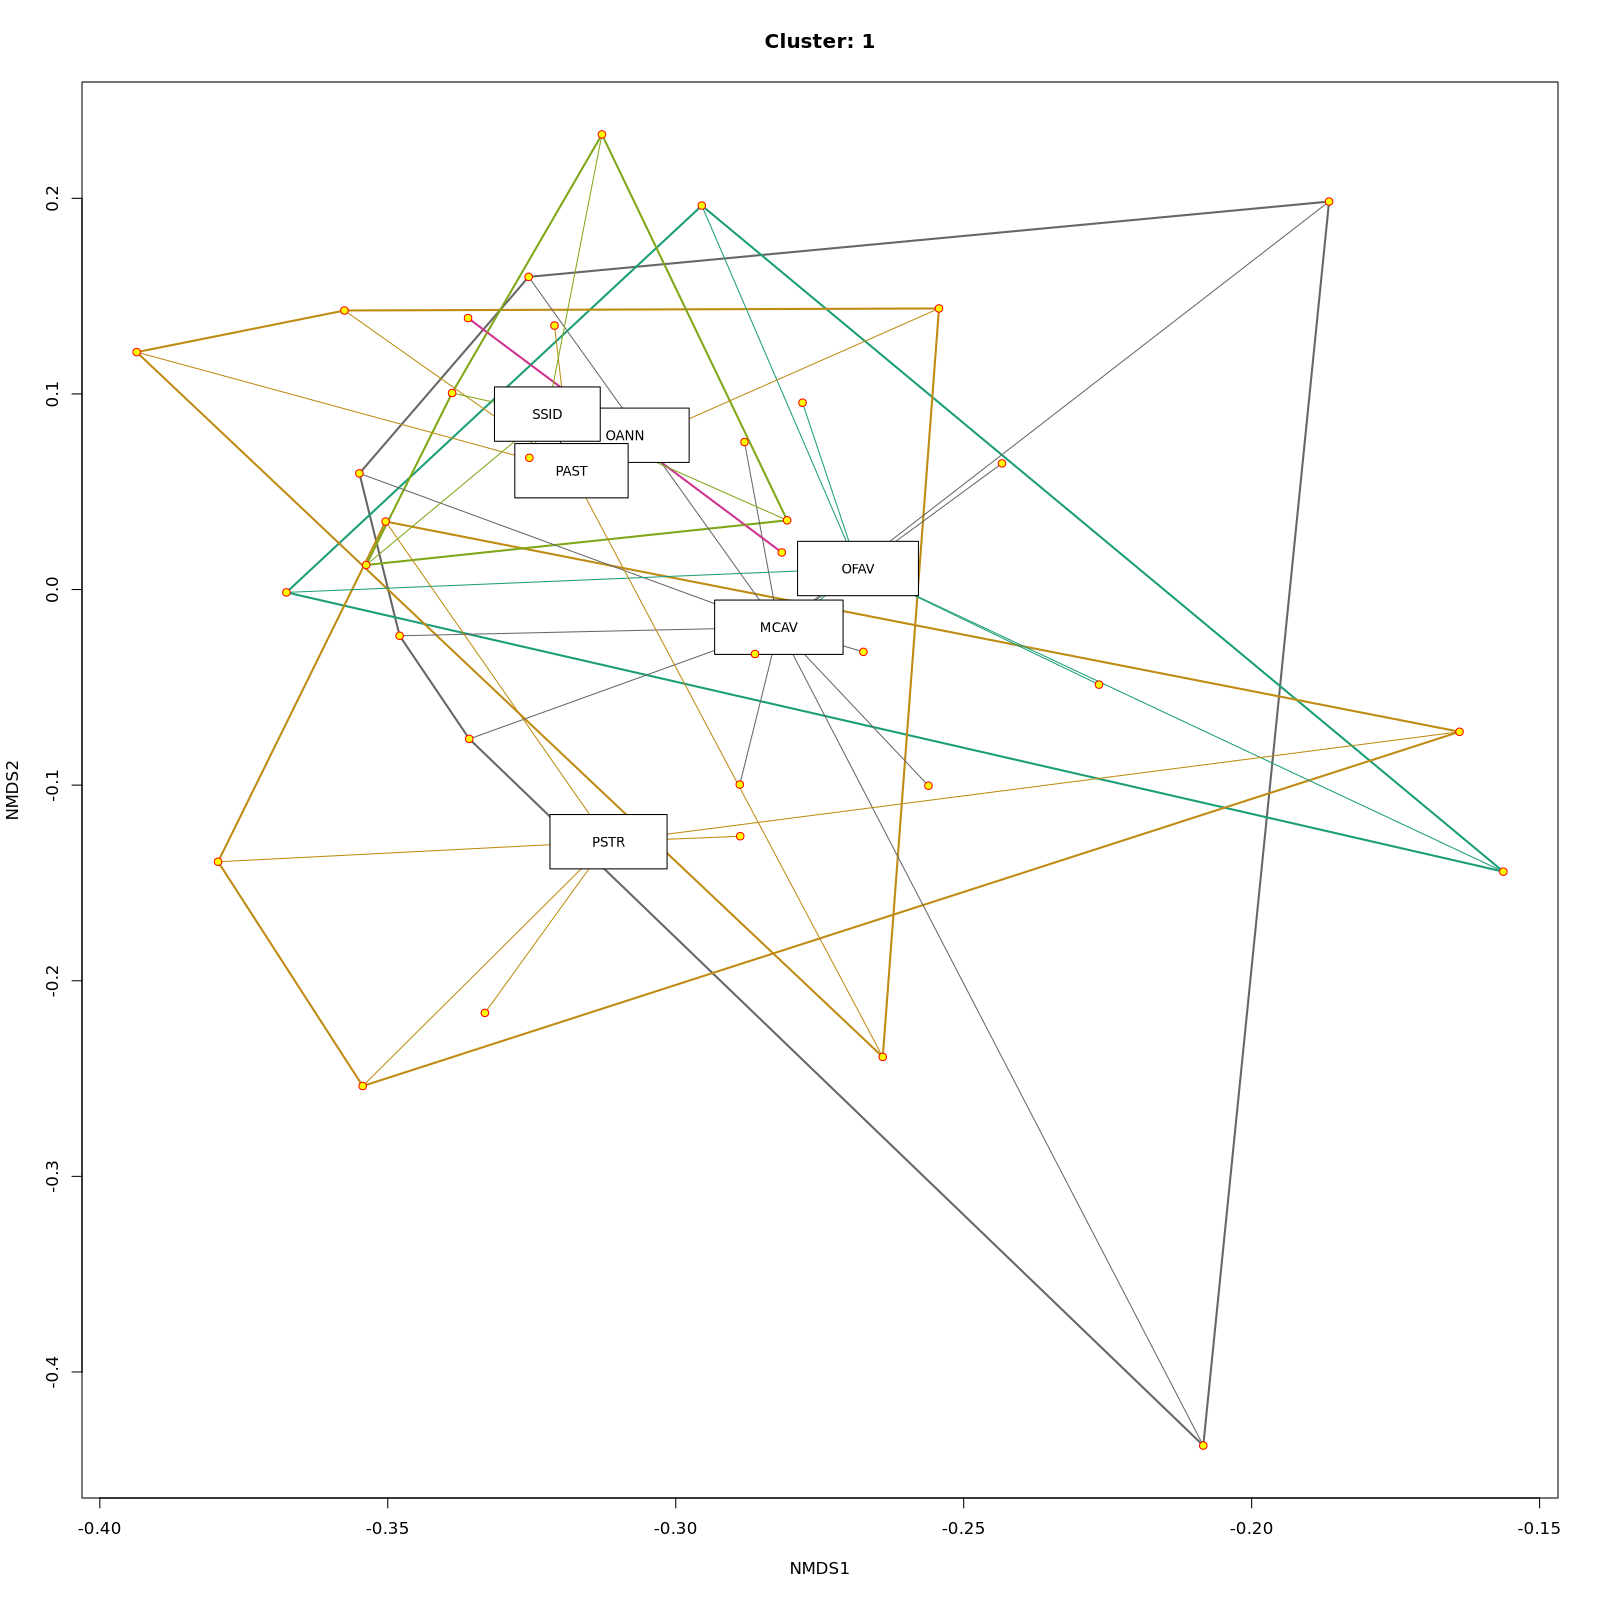

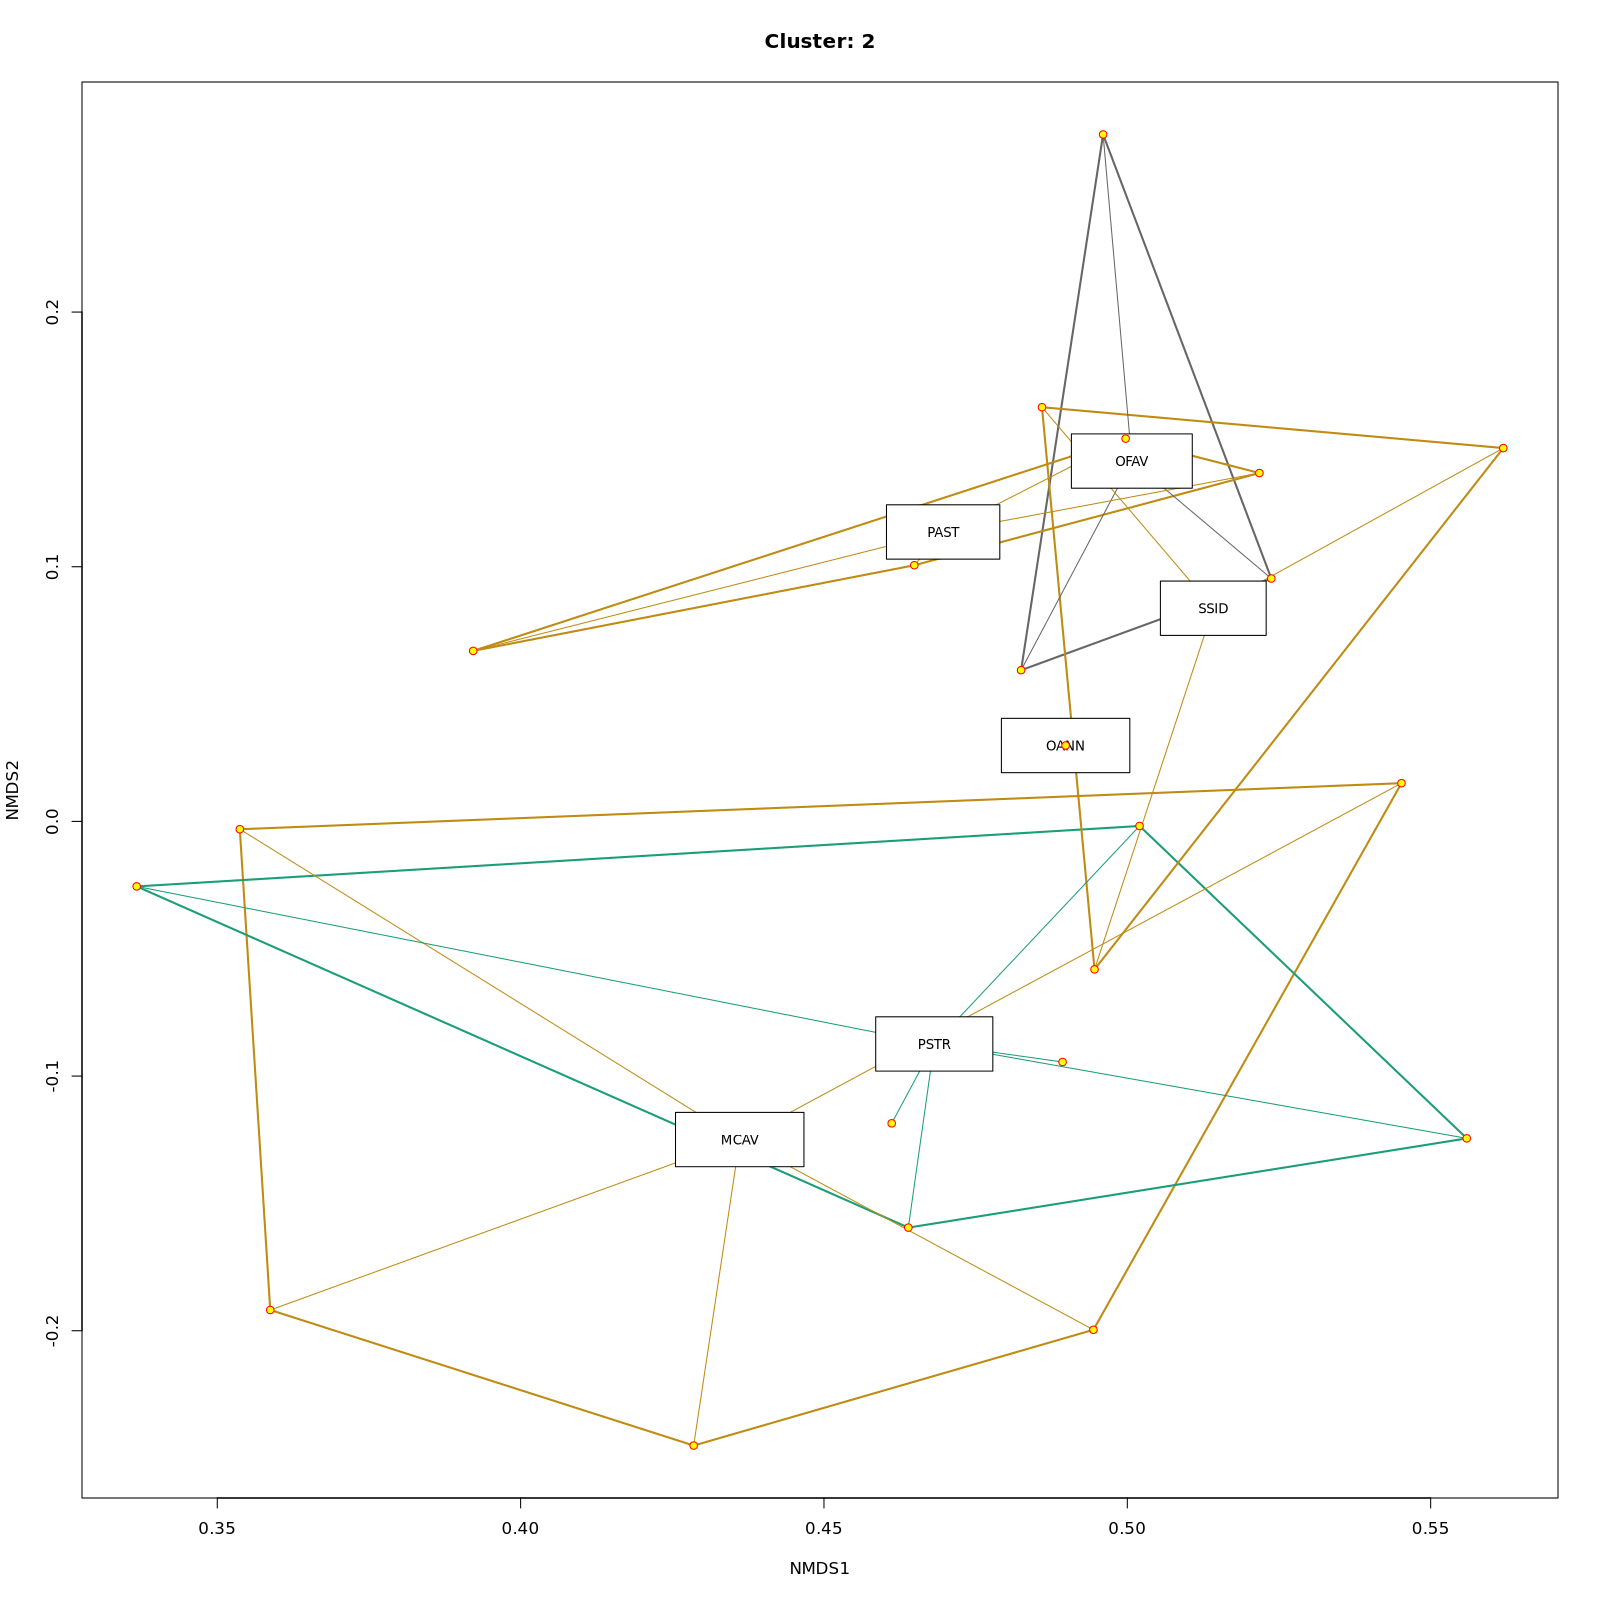

In [164]:
# Step 4: Loop through each cluster to "facet" the plot
for (cl in clusters) {
  # Filter for this cluster
  idx <- nmds_merged$ParentCluster == cl

  # Subset site coordinates and metadata
  sub_scores <- site_scores[idx, , drop = FALSE]
  sub_species <- nmds_merged$species[idx]
  sub_colors <- color_veg[idx]

  # Plot
  plot(sub_scores, type = "n", main = paste("Cluster:", cl))
  ordihull(sub_scores, groups = sub_species, col = sub_colors, lwd = 2)
  ordispider(sub_scores, groups = sub_species, col = sub_colors, label = TRUE)
  points(sub_scores, pch = 21, col = "red", bg = "yellow")
}

## actually hierarchical clustering is not ideal for the level of nesting I have going on
Hierarchies rely on a tree-like structure called a dendrogram. In an agglomerative (bottom-up) approach, clusters are successively merged, and a data point remains within the lineage of the cluster it first joins.
basically if two species are idependently in different groups, dendogram doesn't know what to do with it

## using vegan to try to plot what I have above with more control over colors

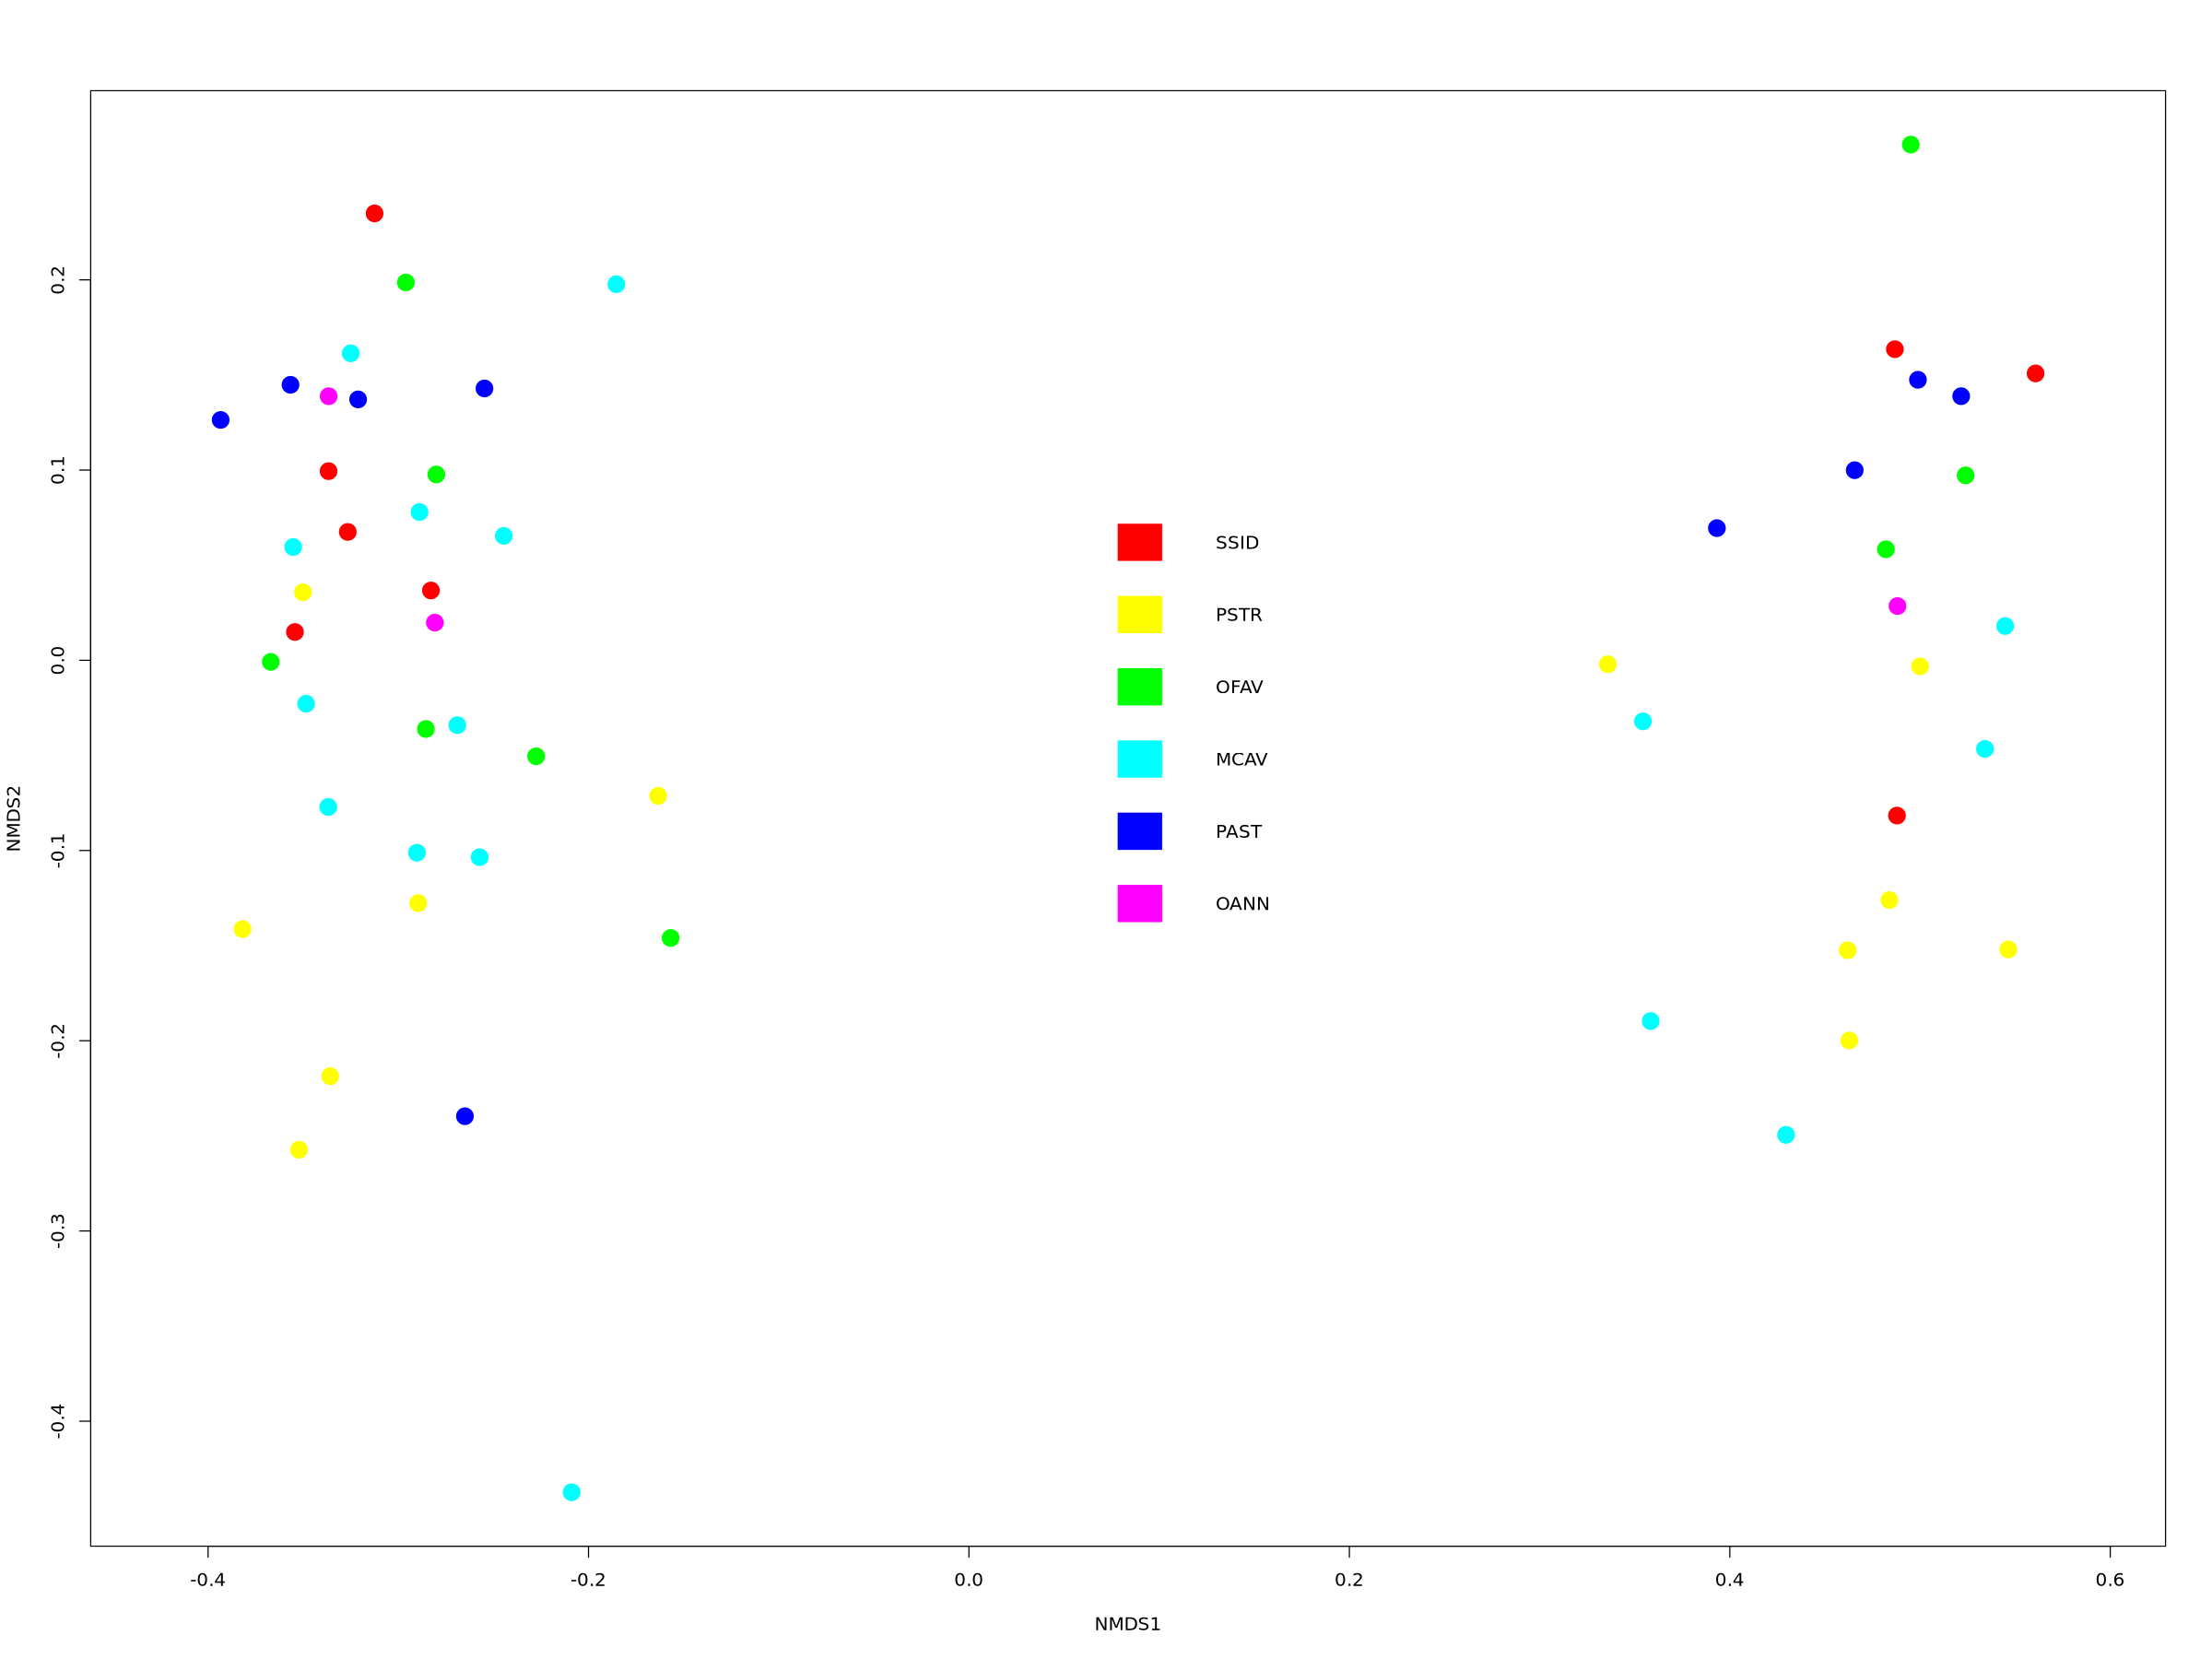

In [136]:
#plot ellipsoid hulls hierarchal clustering Date_16S and species
disp <- "sites" 
scl <- "symmetric" 
# Base NMDS plot (no points yet)
plot(NMDS_nochlo, type = "n", display = disp)
#add larger clusters Date_16S
ordiellipse(NMDS_nochlo,
            groups = sample_nochlo$species_clean,
            kind = "ehull",
            col = col_spec,
            lwd = 3,
            lty = 2)
# Ellipses by species
ordiellipse(NMDS_nochlo, groups = sample_nochlo$species_clean,
            draw = "polygon",
            col = col_spec,
            alpha = 80,
            lwd = 2)
# Optional spiders
ordispider(NMDS_nochlo, groups = sample_nochlo$species_clean,
           col = col_spec,
           label = FALSE)

points(NMDS_nochlo, display = "sites", 
       pch = 21, 
       cex = 2, 
       col = group_colors, 
       bg = group_colors)

# Legend by species
legend(0.05,0.1, legend = names(col_spec),
       fill = col_spec,
       border = col_spec,
       bty = "n")
     

# in the future I may want to subset by things in the sample_norm

ps_MCAV = subset_samples(DE, species%in%c("MCAV"))
ps_SSID = subset_samples(DE, species%in%c("SSID"))